In [ ]:
!pip install lifelines --quiet

import pandas as pd

file_path = "/content/LungBrainMets-20241001DEIDENTIFIEDCOPYWITHLINKAGECODE.xlsx"
df = pd.read_excel(file_path)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.9 MB/s eta 0:00:00


##Demographics

In [ ]:
import numpy as np
import pandas as pd

# --- AGE CLEANING AND BINNING ---
df['Age at primary Diagnosis'] = pd.to_numeric(df['Age at primary Diagnosis'], errors='coerce')

df['Age_flag'] = np.where(
    df['Age at primary Diagnosis'].between(20, 100, inclusive="both"),
    'OK',
    'Check'
)

df['Age_Group'] = pd.cut(
    df['Age at primary Diagnosis'],
    bins=[0, 49, 59, 69, 79, 89, 120],
    labels=['<50', '50–59', '60–69', '70–79', '80–89', '90+']
)

# --- GENDER CLEANING ---
g = df['Gender']

# treat common null tokens as missing BEFORE string ops
g = g.replace(['(null)', '(NULL)', 'NULL', 'null', '0', '', ' '], np.nan)

g = g.astype('string').str.strip().str.upper()

g = g.replace({
    'M': 'MALE',
    'F': 'FEMALE'
})

df['Gender'] = np.where(g.isna(), 'Other/Unknown',
                        np.where(g.isin(['MALE', 'FEMALE']), g.str.title(), 'Other/Unknown'))

# --- COUNTRY OF BIRTH TO REGION MAPPING ---
c = df['Country of birth']
c = c.replace(['(null)', '(NULL)', 'NULL', 'null', '0', '', ' '], np.nan)
c = c.astype('string').str.strip().str.title()

df['Country of birth'] = c

pacific = {'New Zealand','Fiji','Papua New Guinea','Samoa','Tonga','Vanuatu','Cook Islands','Solomon Islands'}
australia = {'Australia'}
europe = {
    'Austria','Belgium','England','France','Germany','Greece','Hungary','Ireland',
    'Italy','Netherlands','Poland','Portugal','Scotland','Spain','Sweden','Switzerland',
    'Wales','United Kingdom','United Kingdom, Channels Islands','United Kingdom, Channel Islands A'
}
asia = {'India','China','Vietnam','Philippines','Malaysia','Indonesia','Sri Lanka','Pakistan','Bangladesh','Thailand','Singapore','Nepal','Japan','South Korea'}
africa = {'South Africa','Egypt','Nigeria','Kenya','Zimbabwe','Sudan','Ethiopia'}
americas = {'United States','Canada','Mexico','Brazil','Chile'}

def map_region(country):
    if pd.isna(country):
        return 'Unknown'
    if country in australia:
        return 'Australia'
    if country in pacific:
        return 'Pacific'
    if country in europe:
        return 'Europe'
    if country in asia:
        return 'Asia'
    if country in africa:
        return 'Africa'
    if country in americas:
        return 'Americas'
    return 'Other'

df['Region of birth'] = df['Country of birth'].apply(map_region)


##Diagnosis

In [ ]:
import pandas as pd
import numpy as np
import re

# --- PRIMARY CANCER SITE (ICD-10) ---

# Keep only lung ICD-10 codes C34.x. If missing/invalid, set to C34.9 (unspecified lung).
s = df['Primary cancer site'].astype(str).str.upper()
df['Primary cancer site'] = s.str.extract(r'(C34\.\d)')[0]

icd_site_mapping = {
    'C34.0': 'Main bronchus',
    'C34.1': 'Upper lobe',
    'C34.2': 'Middle lobe',
    'C34.3': 'Lower lobe',
    'C34.8': 'Overlapping lesion',
    'C34.9': 'Unspecified lung'
}
df['Primary site label'] = df['Primary cancer site'].map(icd_site_mapping).fillna('Unspecified lung')


# --- DIAGNOSIS CLASS ---

diag = df['Diagnosis_Class'].astype(str).str.strip().str.lower()
diag_map = {
    'primary': 'Primary',
    'recurrent': 'Recurrent',
    'restage': 'Restage',
    'related': 'Related'
}
df['Diagnosis_Class'] = diag.map(diag_map).fillna('Other/Unknown')


# --- MORPHOLOGY ---

df['Morphology'] = df['Morphology'].astype(str).str.strip().str.upper()

morphology_map = {
    '8140/3': 'Adenocarcinoma',
    '8070/3': 'Squamous cell carcinoma',
    '8041/3': 'Small cell carcinoma',
    '8480/3': 'Mucinous adenocarcinoma',
    '8012/3': 'Large cell carcinoma'
}
df['Morphology_Grouped'] = df['Morphology'].map(morphology_map).fillna('Other')


# --- LATERALITY ---

lat = df['Laterality']
lat = lat.replace(['(Null)', '(null)', 'Null', 'NULL', 'null', '0', '', ' '], np.nan)
lat = lat.astype(str).str.strip()

def map_laterality(value):
    v = str(value).strip().lower()
    if v in ['nan', 'na', 'null', '(null)', '', '9 - unknown side', 'unknown']:
        return 'Unknown'

    if ('left' in v) and ('right' in v):
        return 'Bilateral'
    if 'bilateral' in v or 'simultan' in v:
        return 'Bilateral'
    if 'left' in v:
        return 'Left'
    if 'right' in v:
        return 'Right'
    if any(k in v for k in ['carina', 'central', 'medial', 'apical']):
        return 'Central'
    return 'Unknown'

df['Laterality_Clean'] = lat.apply(map_laterality)


# --- ECOG PERFORMANCE STATUS ---

df['ECOG_raw'] = df['ECOG'].astype(str).str.strip().str.lower()

def parse_ecog(value):
    v = str(value).strip().lower()
    if v in ['(null)', 'null', '', 'nan', '9 - unknown', '9', 'unknown']:
        return np.nan
    if v == '0' or v.startswith('0 -'):
        return 0
    if v.startswith('1 -'):
        return 1
    if v.startswith('2 -'):
        return 2
    if v.startswith('3 -'):
        return 3
    if v.startswith('4 -'):
        return 4
    return np.nan

df['ECOG_score'] = df['ECOG_raw'].apply(parse_ecog)

ecog_map = {
    0: 'Fully active',
    1: 'Ambulatory, light activity',
    2: 'Self-care, limited work',
    3: 'Limited self-care, mostly bedridden',
    4: 'Completely disabled'
}
df['ECOG_category'] = df['ECOG_score'].map(ecog_map)

##Staging

In [ ]:
import numpy as np
import pandas as pd
import re
from pandas.api.types import CategoricalDtype

valid_t = ['T0','T1','T1A','T1B','T2','T2A','T2B','T3','T4']
valid_n = ['N0','N1','N2','N3']
valid_m = ['M0','M1','M1A','M1B','M1C']

NULL_STRINGS = {'ERROR','NAN','NULL','(NULL)','NONE','', '(null)', 'null'}

def clean_stage_series(s: pd.Series) -> pd.Series:
    s2 = s.where(s.notna(), np.nan).astype(str).str.strip().str.upper()
    s2 = s2.replace({k: np.nan for k in NULL_STRINGS})
    # normalize NOS patterns
    s2 = s2.replace({
        'T1NOS':'T1','T2NOS':'T2','T3NOS':'T3','T4NOS':'T4',
        'N0NOS':'N0','N1NOS':'N1','N2NOS':'N2','N3NOS':'N3',
        'M0NOS':'M0','M1NOS':'M1'
    })
    return s2

stage_cols = [
    'T stage clinical','N stage clinical','M stage clinical',
    'T stage pathological','N stage pathological','M stage pathological',
    'TNM stage clinical','TNM stage pathological'
]
for col in stage_cols:
    if col in df.columns:
        df[col] = clean_stage_series(df[col])

def parse_tnm(tnm_str):
    if pd.isna(tnm_str):
        return None, None, None
    s = str(tnm_str).upper()
    s = re.sub(r'\s+', '', s)

    # find T, N, M anywhere in the string
    t_match = re.search(r'T(0|1A|1B|1C|1|2A|2B|2|3|4)', s)
    n_match = re.search(r'N(0|1|2|3)', s)
    m_match = re.search(r'M(0|1A|1B|1C|1)', s)

    t = f"T{t_match.group(1)}" if t_match else None
    n = f"N{n_match.group(1)}" if n_match else None
    m = f"M{m_match.group(1)}" if m_match else None

    # normalize M1 -> M1 (do NOT force M1B)
    if m == 'M1':
        m = 'M1'

    return t, n, m

def get_final_stage(row, stage_type):
    valid_set = valid_t if stage_type == 'T' else valid_n if stage_type == 'N' else valid_m

    clinical = row.get(f"{stage_type} stage clinical")
    pathological = row.get(f"{stage_type} stage pathological")

    for val in [clinical, pathological]:
        if val in valid_set:
            return val

    t_c, n_c, m_c = parse_tnm(row.get('TNM stage clinical'))
    t_p, n_p, m_p = parse_tnm(row.get('TNM stage pathological'))

    parsed_map = {'T': [t_c, t_p], 'N': [n_c, n_p], 'M': [m_c, m_p]}
    for val in parsed_map[stage_type]:
        if val in valid_set:
            return val

    return np.nan

df['T_stage_final'] = df.apply(lambda r: get_final_stage(r, 'T'), axis=1)
df['N_stage_final'] = df.apply(lambda r: get_final_stage(r, 'N'), axis=1)
df['M_stage_final'] = df.apply(lambda r: get_final_stage(r, 'M'), axis=1)

def derive_stage_coarse(t, n, m):
    if pd.isna(t) or pd.isna(n) or pd.isna(m):
        return np.nan
    if m != 'M0':
        return 'Stage IV'
    if t in ['T0','T1','T1A','T1B','T2','T2A'] and n == 'N0':
        return 'Stage I'
    if (t in ['T2B','T3'] and n == 'N0') or (t in ['T1','T2','T2A'] and n == 'N1'):
        return 'Stage II'
    if (t in ['T1','T2','T2A','T2B','T3'] and n == 'N2') or (t == 'T4' and n in ['N0','N1','N2']) or (n == 'N3'):
        return 'Stage III'
    return np.nan

df['Stage_Grouped_Final'] = df.apply(lambda r: derive_stage_coarse(r['T_stage_final'], r['N_stage_final'], r['M_stage_final']), axis=1)

# pull stage labels if present (I/II/III/IV)
lab = df['TNM stage clinical'].where(df['TNM stage clinical'].notna(), np.nan).astype(str)
df['TNM_stage_label'] = lab.str.extract(r'(?:STAGE\s*)?([IVX]{1,4}[A-C]?)', flags=re.IGNORECASE)[0]
df['TNM_stage_label'] = df['TNM_stage_label'].str.upper().str.replace(' ', '')

stage_map = {
    'I':'Stage I','IA':'Stage I','IB':'Stage I','IA1':'Stage I','IA2':'Stage I','IA3':'Stage I',
    'II':'Stage II','IIA':'Stage II','IIB':'Stage II',
    'III':'Stage III','IIIA':'Stage III','IIIB':'Stage III','IIIC':'Stage III',
    'IV':'Stage IV','IVA':'Stage IV','IVB':'Stage IV','IVC':'Stage IV'
}
df['Stage_From_TNM_Label'] = df['TNM_stage_label'].map(stage_map)
df['Stage_Grouped_Final'] = df['Stage_Grouped_Final'].fillna(df['Stage_From_TNM_Label'])

stage_order = CategoricalDtype(categories=['Stage I','Stage II','Stage III','Stage IV'], ordered=True)
df['Stage_Grouped_Final'] = df['Stage_Grouped_Final'].astype(stage_order)


##Timelines

In [ ]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

def coerce_date(s):
    """Robust Excel-friendly date parsing."""
    if s is None:
        return pd.NaT
    s = s.astype(str).str.strip()

    # Common garbage / null-like tokens
    s = s.replace({
        '(null)': np.nan, '(NULL)': np.nan, 'NULL': np.nan, 'null': np.nan,
        'NaN': np.nan, 'nan': np.nan, '0': np.nan, '': np.nan, ' ': np.nan
    })

    # If strings contain extra text, pull first YYYY-MM-DD if present
    # (keeps your earlier "Diagnosis date (Primary)" fix but generalized)
    extracted = s.str.extract(r'(\d{4}-\d{2}-\d{2})', expand=False)
    s = extracted.fillna(s)

    # Let pandas infer (handles dd/mm/yyyy, Excel timestamps, etc.)
    return pd.to_datetime(s, errors='coerce', dayfirst=True)

def days_between(later, earlier):
    d = (later - earlier).dt.days
    d = d.where(d >= 0)  # drop negatives only
    return d

date_cols = [
    'Primary diagnosis date', 'Diagnosis date',
    'Referral date', 'First consult date',
    'MDT date (recorded)', 'MDT date (actual)',
    'ECOG Date', 'Follow up status date',
    'Sugery date', 'Surgery date',
    'Radiotherapy start date', 'Radiotherapy end date',
    'Ready for care date',
    'chemo episode start date', 'chemo episode end date',
    'Recurrence diagnosis date',
    'Metastasis diagnosis date 1', 'Metastasis diagnosis date 2', 'Metastasis diagnosis date 3',
    'Date of death',
    'TNM Staging Date clinical', 'TNM Staging Date pathological'
]

for col in date_cols:
    if col in df.columns:
        df[col] = coerce_date(df[col])

# Choose whichever surgery column exists
surg_col = None
if 'Sugery date' in df.columns:
    surg_col = 'Sugery date'
elif 'Surgery date' in df.columns:
    surg_col = 'Surgery date'


idx = 'Primary diagnosis date'

df['Days_to_Referral']         = days_between(df.get('Referral date'), df[idx]) if 'Referral date' in df.columns else np.nan
df['Days_to_First_Consult']    = days_between(df.get('First consult date'), df[idx]) if 'First consult date' in df.columns else np.nan
df['Days_to_MDT_Recorded']     = days_between(df.get('MDT date (recorded)'), df[idx]) if 'MDT date (recorded)' in df.columns else np.nan
df['Days_to_MDT_Actual']       = days_between(df.get('MDT date (actual)'), df[idx]) if 'MDT date (actual)' in df.columns else np.nan
df['Days_to_Ready_for_Care']   = days_between(df.get('Ready for care date'), df[idx]) if 'Ready for care date' in df.columns else np.nan

df['Days_to_Chemo_Start']      = days_between(df.get('chemo episode start date'), df[idx]) if 'chemo episode start date' in df.columns else np.nan
df['Days_to_Chemo_End']        = days_between(df.get('chemo episode end date'), df[idx]) if 'chemo episode end date' in df.columns else np.nan
df['Chemo_duration']           = days_between(df.get('chemo episode end date'), df.get('chemo episode start date')) if all(c in df.columns for c in ['chemo episode start date','chemo episode end date']) else np.nan
df['Days_MDT_to_Chemo']        = days_between(df.get('chemo episode start date'), df.get('MDT date (actual)')) if all(c in df.columns for c in ['MDT date (actual)','chemo episode start date']) else np.nan

df['Days_to_Radiotherapy_Start'] = days_between(df.get('Radiotherapy start date'), df[idx]) if 'Radiotherapy start date' in df.columns else np.nan
df['Days_to_Radiotherapy_End']   = days_between(df.get('Radiotherapy end date'), df[idx]) if 'Radiotherapy end date' in df.columns else np.nan
df['Radiotherapy_duration']      = days_between(df.get('Radiotherapy end date'), df.get('Radiotherapy start date')) if all(c in df.columns for c in ['Radiotherapy start date','Radiotherapy end date']) else np.nan

df['Days_to_Surgery'] = days_between(df.get(surg_col), df[idx]) if surg_col else np.nan
df['Days_to_ECOG']    = days_between(df.get('ECOG Date'), df[idx]) if 'ECOG Date' in df.columns else np.nan


# Last contact: prefer follow-up, else RT end, else chemo end
last_contact_candidates = [c for c in ['Follow up status date', 'Radiotherapy end date', 'chemo episode end date'] if c in df.columns]
df['Last_Contact_Date'] = df[last_contact_candidates].max(axis=1) if last_contact_candidates else pd.NaT

df['OS_Event'] = np.where(df.get('Date of death').notna(), 1, 0) if 'Date of death' in df.columns else 0
df['OS_End_Point'] = df.get('Date of death').fillna(df['Last_Contact_Date']) if 'Date of death' in df.columns else df['Last_Contact_Date']
df['OS_Days'] = days_between(df['OS_End_Point'], df[idx])

# (Optional) drop impossible/empty follow-up
df.loc[df['OS_Days'].isna(), 'OS_Event'] = np.nan  # signals unusable row for OS


event_cols = [c for c in [
    'Recurrence diagnosis date',
    'Metastasis diagnosis date 1',
    'Metastasis diagnosis date 2',
    'Metastasis diagnosis date 3',
    'Date of death'
] if c in df.columns]

df['Progression_Event_Date'] = df[event_cols].min(axis=1) if event_cols else pd.NaT

df['PFS_Event'] = np.where(df['Progression_Event_Date'].notna(), 1, 0)
df['PFS_End_Point'] = df['Progression_Event_Date'].fillna(df['Last_Contact_Date'])
df['PFS_Days'] = days_between(df['PFS_End_Point'], df[idx])

# If you want to drop 0-day PFS only (but keep same-day events), change to <0 above.
df.loc[df['PFS_Days'].isna(), 'PFS_Event'] = np.nan  # unusable for KM if no time


df['Days_to_Recurrence'] = days_between(df.get('Recurrence diagnosis date'), df[idx]) if 'Recurrence diagnosis date' in df.columns else np.nan
df['Days_to_Death']      = days_between(df.get('Date of death'), df[idx]) if 'Date of death' in df.columns else np.nan
df['Days_to_Followup']   = days_between(df.get('Follow up status date'), df[idx]) if 'Follow up status date' in df.columns else np.nan


print("--- Timeline Processing Complete ---")
print(f"Total patients: {len(df)}")

if 'OS_Days' in df.columns:
    print(f"Valid OS days: {df['OS_Days'].notna().sum()}")
    print(f"OS events (deaths): {int(np.nansum(df['OS_Event']))}")

if 'PFS_Days' in df.columns:
    print(f"Valid PFS days: {df['PFS_Days'].notna().sum()}")
    print(f"PFS events: {int(np.nansum(df['PFS_Event']))}")

print("\nSample rows:")
show_cols = [c for c in [
    'Primary diagnosis date', 'Last_Contact_Date',
    'Date of death', 'OS_End_Point', 'OS_Event', 'OS_Days',
    'Progression_Event_Date', 'PFS_End_Point', 'PFS_Event', 'PFS_Days'
] if c in df.columns]
print(df[show_cols].head())


--- Timeline Processing Complete ---
Total patients: 116553
Valid OS days: 46513
OS events (deaths): 35804
Valid PFS days: 45820
PFS events: 38683

Sample rows:
  Primary diagnosis date Last_Contact_Date Date of death OS_End_Point  \
0             2023-02-11        2024-01-24           NaT   2024-01-24   
1             2023-02-11        2024-01-24           NaT   2024-01-24   
2             2023-02-11        2024-01-24           NaT   2024-01-24   
3             2023-02-11        2024-01-24           NaT   2024-01-24   
4             2023-02-11        2024-01-24           NaT   2024-01-24   

   OS_Event  OS_Days Progression_Event_Date PFS_End_Point  PFS_Event  PFS_Days  
0       0.0    347.0                    NaT    2024-01-24        0.0     347.0  
1       0.0    347.0                    NaT    2024-01-24        0.0     347.0  
2       0.0    347.0                    NaT    2024-01-24        0.0     347.0  
3       0.0    347.0                    NaT    2024-01-24        0.0     347

##Treatment

Surgery

In [ ]:
import numpy as np
import pandas as pd

date_col_name = 'Sugery date' if 'Sugery date' in df.columns else 'Surgery date'
surgery_df = df[['LINKAGE CODE', 'Procedure name', date_col_name]].copy()

# --- STEP 1: CLEANING ---
surgery_df['Surgery_Date_Clean'] = pd.to_datetime(surgery_df[date_col_name], errors='coerce')

# Keep missing as missing (don't force to string)
proc = surgery_df['Procedure name']

# Normalize to clean strings, but preserve NA
proc = proc.where(proc.notna(), pd.NA)
proc = proc.astype("string").str.strip().str.lower()

# Treat common garbage as missing
proc = proc.replace({
    '(null)': pd.NA, 'null': pd.NA, 'nan': pd.NA, 'none': pd.NA, '0': pd.NA, '': pd.NA
})

surgery_df['Proc_Clean'] = proc

# --- STEP 2: CLASSIFICATION LOGIC ---
def classify_surgery(row):
    proc = str(row['Proc_Clean']).lower()

    # 1. EXPLICITLY UNKNOWN/GENERIC -> IGNORE
    if pd.isna(row['Proc_Clean']) or row['Proc_Clean'] == "":
        return 'No Surgery' # Treat date-only as "Not a Lung Resection"

    # 2. DIAGNOSTIC exclusions (Biopsies, etc.)
    if any(x in proc for x in ['biopsy', 'node', 'drain', 'pleurodesis', 'oscopy']):
        return 'Diagnostic/Palliative'

    # 3. CURATIVE LUNG terms only
    curative = ['lobectomy', 'pneumonectomy', 'wedge', 'segmentectomy', 'bilobectomy']
    if any(x in proc for x in curative):
        return 'Lung Surgery'

    return 'Other Surgery'

surgery_df['Surgery_Class'] = surgery_df.apply(classify_surgery, axis=1)

# --- STEP 3: PATIENT PRIORITIZATION ---
priority = {
    'Lung Surgery': 1,
    'Generic Surgery (Date Only)': 2,
    'Non-Lung/Palliative': 3,
    'No Surgery': 99
}
surgery_df['Rank'] = surgery_df['Surgery_Class'].map(priority).fillna(99)

# Deterministic selection: best rank, then earliest surgery date
df_surgery_patients = (
    surgery_df.sort_values(['LINKAGE CODE', 'Rank', 'Surgery_Date_Clean'])
    .groupby('LINKAGE CODE', as_index=False)
    .first()
)

lung_surgery_ids = surgery_df[surgery_df['Surgery_Class'] == 'Lung Surgery']['LINKAGE CODE'].unique()

print(f"Total Patients processed: {len(df_surgery_patients)}")
print(f"Patients identified with Lung/Generic Surgery: {len(lung_surgery_ids)}")
print("\nBreakdown:")
print(df_surgery_patients['Surgery_Class'].value_counts())


Total Patients processed: 2514
Patients identified with Lung/Generic Surgery: 1

Breakdown:
Surgery_Class
No Surgery       2504
Other Surgery       9
Lung Surgery        1
Name: count, dtype: int64


Chemotherapy

In [ ]:
import pandas as pd
import numpy as np

null_values = ['(null)', '(NULL)', 'NULL', 'null', '0', '', ' ', 'NAN', 'NaN', 'nan', None]

for col in ['OMISDrugName', 'NotificationEpisodeChemoRouteID', 'chemo episode start date', 'chemo episode end date']:
    if col in df.columns:
        df[col] = df[col].replace(null_values, np.nan)

chemo_events = df[
    df['chemo episode start date'].notna() |
    df['chemo episode end date'].notna() |
    df['OMISDrugName'].notna()
].copy()

chemo_events['Chemo_Start'] = pd.to_datetime(chemo_events['chemo episode start date'], errors='coerce', dayfirst=True)
chemo_events['Chemo_End']   = pd.to_datetime(chemo_events['chemo episode end date'],   errors='coerce', dayfirst=True)

mask_swapped = chemo_events['Chemo_Start'].notna() & chemo_events['Chemo_End'].notna() & (chemo_events['Chemo_End'] < chemo_events['Chemo_Start'])
chemo_events.loc[mask_swapped, ['Chemo_Start', 'Chemo_End']] = chemo_events.loc[mask_swapped, ['Chemo_End', 'Chemo_Start']].values

chemo_events['Chemo_Event_Date'] = chemo_events['Chemo_Start'].fillna(chemo_events['Chemo_End'])

chemo_events['Drug_Name_Clean'] = (
    chemo_events['OMISDrugName']
    .where(chemo_events['OMISDrugName'].notna(), np.nan)
    .astype('string')
    .str.upper()
    .str.strip()
)

def classify_drug(drug_name):
    if pd.isna(drug_name) or drug_name == '':
        return 'Unknown'

    dn = str(drug_name).upper().strip()

    cytotoxics = [
        'CARBOPLATIN','CISPLATIN','OXALIPLATIN','NEDAPLATIN',
        'PACLITAXEL','DOCETAXEL','ABRAXANE','NAB-PACLITAXEL',
        'VINORELBINE','VINCRISTINE','VINDESINE',
        'GEMCITABINE','PEMETREXED',
        'ETOPOSIDE','TOPOTECAN',
        'CYCLOPHOSPHAMIDE','IFOSFAMIDE',
        'DOXORUBICIN','EPIRUBICIN','ADRIAMYCIN',
        'FLUOROURACIL','5FU','IRINOTECAN'
    ]
    if any(x in dn for x in cytotoxics):
        return 'Cytotoxic'

    immuno = [
        'NIVOLUMAB','PEMBROLIZUMAB','DURVALUMAB','ATEZOLIZUMAB',
        'IPILIMUMAB','PLACEBO'
    ]
    if any(x in dn for x in immuno):
        return 'Immunotherapy'

    targeted = [
        'OSIMERTINIB','GEFITINIB','ERLOTINIB','AFATINIB',
        'ALECTINIB','CRIZOTINIB','CERITINIB','BRIGATINIB','LORLATINIB',
        'DABRAFENIB','TRAMETINIB','SOTORASIB','ADAGRASIB',
        'BEVACIZUMAB','RAMUCIRUMAB',
        'ABBV'
    ]
    if any(x in dn for x in targeted):
        return 'Targeted'

    if 'BACILLUS CALMETTE' in dn or 'OCTREOTIDE' in dn:
        return 'Other_Active'

    supportive = [
        'SALINE','VOLUME','WATER','GLUCOSE','N/S','SODIUM',
        'MAGNESIUM','POTASSIUM','CALCIUM','ELECTROLYTE',
        'DEXAMETHASONE','PREDNISOLONE','HYDROCORTISONE','STEROID',
        'ONDANSETRON','PALONOSETRON','APREPITANT','AKYNZEO','NETUPITANT',
        'RANITIDINE','FAMOTIDINE','PANTOPRAZOLE',
        'PARACETAMOL','MORPHINE','OXYCODONE',
        'LEUCOVORIN','MESNA','FILGRASTIM','PEGFILGRASTIM',
        'ZOMETA','ZOLEDRONIC','PAMIDRONATE','DENOSUMAB','XGEVA',
        'RED BLOOD','PLATELETS','IMMUNOGLOBULIN','PRIVIGEN',
        'LORATADINE','PROMETHAZINE','ATROPINE','VITAMIN'
    ]
    if any(x in dn for x in supportive):
        return 'Supportive'

    return 'Unknown'

chemo_events['Drug_Class'] = chemo_events['Drug_Name_Clean'].apply(classify_drug)

active_chemo = chemo_events[
    chemo_events['Drug_Class'].isin(['Cytotoxic', 'Immunotherapy', 'Targeted', 'Other_Active'])
].copy()

if not active_chemo.empty:
    active_chemo = active_chemo.sort_values(['LINKAGE CODE', 'Chemo_Event_Date'])

    df_chemo_patient = active_chemo.groupby('LINKAGE CODE', as_index=False).agg(
        Chemo_First_Date = ('Chemo_Event_Date', 'min'),
        Chemo_Last_Date  = ('Chemo_Event_Date', 'max'),
        Drug_Classes_Received = ('Drug_Class', lambda x: set(x.dropna()))
    )

    def define_modality(classes):
        if 'Targeted' in classes:
            return 'Targeted Therapy'
        if 'Cytotoxic' in classes and 'Immunotherapy' in classes:
            return 'Chemo-Immunotherapy'
        if 'Immunotherapy' in classes:
            return 'Immunotherapy Only'
        if 'Cytotoxic' in classes:
            return 'Chemotherapy Only'
        if 'Other_Active' in classes:
            return 'Other Active'
        return 'Other'

    df_chemo_patient['Systemic_Category'] = df_chemo_patient['Drug_Classes_Received'].apply(define_modality)
    df_chemo_patient['Chemo_FLAG'] = 1
    df_chemo_patient = df_chemo_patient.drop(columns=['Drug_Classes_Received'])

else:
    df_chemo_patient = pd.DataFrame(columns=[
        'LINKAGE CODE', 'Chemo_First_Date', 'Chemo_Last_Date',
        'Systemic_Category', 'Chemo_FLAG'
    ])

print("--- Systemic Therapy Processing Complete ---")
print(f"Patients with Active Systemic Therapy: {len(df_chemo_patient)}")
if len(df_chemo_patient):
    print("\nBreakdown by Modality:")
    print(df_chemo_patient['Systemic_Category'].value_counts())
print("\nPreview:")
print(df_chemo_patient.head())


--- Systemic Therapy Processing Complete ---
Patients with Active Systemic Therapy: 1026

Breakdown by Modality:
Systemic_Category
Chemotherapy Only      465
Chemo-Immunotherapy    404
Immunotherapy Only     148
Targeted Therapy         7
Other Active             2
Name: count, dtype: int64

Preview:
   LINKAGE CODE Chemo_First_Date Chemo_Last_Date    Systemic_Category  \
0             1       2023-12-11      2024-01-15    Chemotherapy Only   
1             5       2015-04-08      2018-05-30  Chemo-Immunotherapy   
2            10       2014-11-07      2015-05-14    Chemotherapy Only   
3            12       2022-09-29      2024-01-29  Chemo-Immunotherapy   
4            13       2014-12-04      2015-03-04    Chemotherapy Only   

   Chemo_FLAG  
0           1  
1           1  
2           1  
3           1  
4           1  


Radiotherapy

In [ ]:
import pandas as pd
import numpy as np
import re

if 'LINKAGE CODE' not in df.columns:
    raise ValueError("CRITICAL: 'LINKAGE CODE' column missing from dataframe.")

# ----------------------------
# 0) Normalize nulls
# ----------------------------
text_nulls = ['(null)', '(NULL)', 'NULL', 'null', 'NAN', 'nan', '', ' ']
num_nulls  = text_nulls + ['0']

cols_text = ['Radiotherapy site name']
cols_num  = ['Prescribed radiation dose', 'Actual radiation dose', 'actual number of fractions']

for col in cols_text:
    if col in df.columns:
        df[col] = df[col].replace(text_nulls, np.nan)

for col in cols_num:
    if col in df.columns:
        df[col] = df[col].replace(num_nulls, np.nan)

date_cols = ['Radiotherapy start date', 'Radiotherapy end date']
date_nulls = text_nulls + ['0']
for col in date_cols:
    if col in df.columns:
        df[col] = df[col].replace(date_nulls, np.nan)

# ----------------------------
# 1) Keep RT records
# ----------------------------
rt = df[df['Radiotherapy start date'].notna() | df['Radiotherapy end date'].notna()].copy()

rt['RT_Start'] = pd.to_datetime(rt['Radiotherapy start date'], errors='coerce', dayfirst=True)
rt['RT_End']   = pd.to_datetime(rt['Radiotherapy end date'], errors='coerce', dayfirst=True)

mask_swapped = rt['RT_Start'].notna() & rt['RT_End'].notna() & (rt['RT_End'] < rt['RT_Start'])
rt.loc[mask_swapped, ['RT_Start', 'RT_End']] = rt.loc[mask_swapped, ['RT_End', 'RT_Start']].values

rt['RT_Days'] = (rt['RT_End'] - rt['RT_Start']).dt.days
rt.loc[rt['RT_Days'] < 0, 'RT_Days'] = np.nan

# ----------------------------
# 2) Anatomy classification (FIXED REGEX)
# ----------------------------
rt['Site_Raw'] = rt['Radiotherapy site name'].fillna('UNKNOWN').astype(str)
rt['Site_Upper'] = rt['Site_Raw'].str.upper().str.strip()

# FIX: Removed strict trailing boundaries (\b) and added underscore handling
# We now match "LUNG" anywhere, or "LUNG_..."
RE_LUNG = re.compile(r'(LUNG|HILUM|HILAR|MEDIASTIN|LOBE|RUL|RLL|LUL|LLL|RML|CHEST|THORAX|NODES|LN)', re.IGNORECASE)

# These exclusion lists are fine to keep strict or loosen slightly
RE_BRAIN = re.compile(r'(BRAIN|WBRT|CRANIUM|SKULL|HEAD|PCI|METS|CEREB)', re.IGNORECASE)
RE_BONE  = re.compile(r'(SPINE|VERTEBRA|SACRUM|PELVIS|HIP|FEMUR|RIB|SCAPULA|HUMERUS|CLAVICLE|STERNUM)', re.IGNORECASE)
RE_NECK  = re.compile(r'(NECK|SCF|SUPRACLAV|LARYNX|PHARYNX)', re.IGNORECASE)
RE_EXCLUDE_ORGANS = re.compile(r'(LIVER|ADRENAL|KIDNEY|RENAL|PANCREAS|ABDOMEN|STOMACH|BOWEL|COLON|RECTUM|PROSTATE|BREAST)', re.IGNORECASE)

def classify_anatomy(site):
    s = str(site).upper().strip()
    if s in ['', 'UNKNOWN', 'NAN']:
        return 'Unknown'

    # Priority 1: Exclude Brain/Bone (Metastasis sites)
    if RE_BRAIN.search(s):
        return 'Brain'
    if RE_BONE.search(s):
        return 'Bone_Spine'
    if RE_NECK.search(s):
        return 'Neck_Node'
    if RE_EXCLUDE_ORGANS.search(s):
        return 'Other_Organ_Excluded'

    # Priority 2: Include Lung (Now captures LUNG_R, LUNG_L, etc.)
    if RE_LUNG.search(s):
        return 'Lung_Thoracic'

    return 'Other'

rt['Anatomy_Class'] = rt['Site_Upper'].apply(classify_anatomy)

# Check the recovery immediately
print("Lung vs Non-Lung Counts (After Regex Fix):")
print(rt['Anatomy_Class'].value_counts())

# ----------------------------
# 3) Dose / Fractions / BED10
# ----------------------------
rt['Prescribed radiation dose'] = pd.to_numeric(rt['Prescribed radiation dose'], errors='coerce')
rt['Actual radiation dose']     = pd.to_numeric(rt['Actual radiation dose'], errors='coerce')
rt['Fractions']                 = pd.to_numeric(rt['actual number of fractions'], errors='coerce')
rt.loc[rt['Fractions'] <= 0, 'Fractions'] = np.nan

rt['Dose_Raw'] = rt['Actual radiation dose'].fillna(rt['Prescribed radiation dose'])
rt['Dose_Gy']  = np.where(rt['Dose_Raw'] > 200, rt['Dose_Raw'] / 100.0, rt['Dose_Raw'])

rt['Dose_Per_Fraction'] = rt['Dose_Gy'] / rt['Fractions']
rt['BED10'] = rt['Dose_Gy'] * (1 + rt['Dose_Per_Fraction'] / 10)

# ----------------------------
# 4) Technique classification
# ----------------------------
SABR_LABEL_RE = re.compile(r'(SABR|SBRT|STEREOTACTIC)', re.IGNORECASE)

def detect_technique(row):
    site_raw = str(row.get('Site_Upper', row.get('Site_Raw', ''))).upper()

    fx  = row['Fractions']
    bed = row['BED10']
    dpf = row['Dose_Per_Fraction']
    anat = row['Anatomy_Class']

    if pd.isna(fx) or pd.isna(bed) or pd.isna(dpf):
        return 'Palliative_or_Other'

    if anat in ['Brain', 'Bone_Spine', 'Neck_Node', 'Other_Organ_Excluded']:
        return 'Palliative_or_Other'

    has_sabr_label = bool(SABR_LABEL_RE.search(site_raw))

    is_pure_sabr = (fx <= 12) and (bed >= 100) and (dpf >= 4.8)
    is_labeled_sabr = has_sabr_label and (fx <= 12) and (bed >= 70)

    if is_pure_sabr or is_labeled_sabr:
        return 'SABR'

    if (fx >= 15) and (bed >= 50):
        return 'Conventional Radical'

    return 'Palliative_or_Other'

rt['Technique_Class'] = rt.apply(detect_technique, axis=1)

# ----------------------------
# 5) Choose FIRST Lung RT (With "Anti-Leak" Filter)
# ----------------------------

# 1. Broaden filter to catch 'Other' (Generic sites), but...
target_anatomy = ['Lung_Thoracic', 'Other', 'Unknown']
lung_rt = rt[rt['Anatomy_Class'].isin(target_anatomy)].copy()

# 2. SAFETY CHECK: Explicitly drop "Leakage" keywords from the 'Other' bucket
#    (Test 1 showed 'WHOLE BRAIN' slipping into 'Other')
leak_pattern = r'(BRAIN|CEREB|HEAD|SPINE|VERTEBRA|PELVIS|HIP|BONE|METS|NECK|LIVER|ABDOMEN)'
mask_leak = (
    (lung_rt['Anatomy_Class'].isin(['Other', 'Unknown'])) &
    (lung_rt['Site_Upper'].str.contains(leak_pattern, regex=True))
)
print(f"⚠️ Dropping {mask_leak.sum()} rows of 'Other' anatomy that matched Brain/Bone keywords.")
lung_rt = lung_rt[~mask_leak].copy()

# 3. Date Rescue (Use End if Start missing)
lung_rt['Best_Start_Date'] = lung_rt['RT_Start'].fillna(lung_rt['RT_End'])
lung_rt = lung_rt.dropna(subset=['Best_Start_Date'])

# 4. Find Absolute First Date
first_dates = lung_rt.groupby('LINKAGE CODE')['Best_Start_Date'].min().reset_index()
first_dates = first_dates.rename(columns={'Best_Start_Date': 'First_Ever_RT'})

# 5. Window Logic (0-30 days)
lung_rt = lung_rt.merge(first_dates, on='LINKAGE CODE', how='left')
lung_rt['Days_From_First'] = (lung_rt['Best_Start_Date'] - lung_rt['First_Ever_RT']).dt.days
primary_window_rt = lung_rt[lung_rt['Days_From_First'] <= 30].copy()

# 6. Priority Rank (SABR > Conv > Pall)
def assign_priority(technique):
    if technique == 'SABR': return 1
    if technique == 'Conventional Radical': return 2
    return 3

primary_window_rt['Selection_Rank'] = primary_window_rt['Technique_Class'].apply(assign_priority)

# 7. Sort and Pick Top
rt_sorted = primary_window_rt.sort_values(
    by=['LINKAGE CODE', 'Selection_Rank', 'Best_Start_Date'],
    ascending=[True, True, True]
)

df_rt_patient = rt_sorted.groupby('LINKAGE CODE', as_index=False).first()

# Rename columns for Master Table merge
df_rt_final = df_rt_patient[[
    'LINKAGE CODE', 'Best_Start_Date', 'RT_End', 'RT_Days',
    'Site_Raw', 'Anatomy_Class', 'Technique_Class', 'BED10'
]].rename(columns={
    'Best_Start_Date': 'RT_Primary_Start', # Use the Rescued Date
    'RT_End': 'RT_Primary_End',
    'Site_Raw': 'RT_Primary_Site_Name',
    'Technique_Class': 'RT_Primary_Technique',
    'Anatomy_Class': 'RT_Primary_Anatomy',
    'BED10': 'RT_Primary_BED10'
})

# Flags
df_rt_final['Lung_RT_FLAG'] = 1
df_rt_final['SABR_FLAG_Primary'] = (df_rt_final['RT_Primary_Technique'] == 'SABR').astype(int)

# (Step 6 continues as normal...)
# ----------------------------
# 6) Final patient-level RT table
# ----------------------------
df_rt_final = df_rt_patient[[
    'LINKAGE CODE', 'RT_Start', 'RT_End', 'RT_Days',
    'Site_Raw', 'Anatomy_Class', 'Technique_Class',
    'BED10'
]].rename(columns={
    'RT_Start': 'RT_Primary_Start',
    'RT_End': 'RT_Primary_End',
    'RT_Days': 'RT_Primary_Duration_days',
    'Site_Raw': 'RT_Primary_Site_Name',
    'Technique_Class': 'RT_Primary_Technique',
    'Anatomy_Class': 'RT_Primary_Anatomy',
    'BED10': 'RT_Primary_BED10'
})

mask_rescue = df_rt_final['RT_Primary_Start'].isna() & df_rt_final['RT_Primary_End'].notna()
df_rt_final.loc[mask_rescue, 'RT_Primary_Start'] = (
    df_rt_final.loc[mask_rescue, 'RT_Primary_End'] - pd.to_timedelta(14, unit='D')
)

mask_has_both = df_rt_final['RT_Primary_Start'].notna() & df_rt_final['RT_Primary_End'].notna()
df_rt_final.loc[mask_has_both, 'RT_Primary_Duration_days'] = (
    df_rt_final.loc[mask_has_both, 'RT_Primary_End'] - df_rt_final.loc[mask_has_both, 'RT_Primary_Start']
).dt.days

df_rt_final['Lung_RT_FLAG'] = 1
df_rt_final['SABR_FLAG'] = (df_rt_final['RT_Primary_Technique'] == 'SABR').astype(int)
df_rt_final['SABR_FLAG_Primary'] = df_rt_final['SABR_FLAG'].astype(int)

print("--- RT Processing Complete (Final) ---")
print(f"Total Unique Patients: {len(df_rt_final)}")
print("\nTechnique Breakdown (First Course Only):")
print(df_rt_final['RT_Primary_Technique'].value_counts(dropna=False))

sabr_only = df_rt_final[df_rt_final['RT_Primary_Technique'] == 'SABR']
print(f"\nSABR Patients: {len(sabr_only)}")
print("SABR Years:")
print(sabr_only['RT_Primary_Start'].dt.year.value_counts().sort_index())

/tmp/ipython-input-1910789866.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(num_nulls, np.nan)


Lung vs Non-Lung Counts (After Regex Fix):
Anatomy_Class
Lung_Thoracic           34980
Brain                   11038
Bone_Spine              10312
Other                    9811
Neck_Node                2604
Other_Organ_Excluded      575
Name: count, dtype: int64
⚠️ Dropping 1 rows of 'Other' anatomy that matched Brain/Bone keywords.
--- RT Processing Complete (Final) ---
Total Unique Patients: 1157

Technique Breakdown (First Course Only):
RT_Primary_Technique
Palliative_or_Other     534
Conventional Radical    484
SABR                    139
Name: count, dtype: int64

SABR Patients: 139
SABR Years:
RT_Primary_Start
2017     4
2018    15
2019    10
2020    17
2021    21
2022    20
2023    33
2024    19
Name: count, dtype: int64


##Outcomes

In [ ]:
import numpy as np
import pandas as pd
import warnings

df = df.copy()

NULL_MAP_NO_ZERO = {
    '(null)': np.nan, '(NULL)': np.nan, 'null': np.nan, 'NULL': np.nan,
    'NaN': np.nan, 'nan': np.nan, 'NAN': np.nan, '': np.nan, ' ': np.nan
}
NULL_MAP_WITH_ZERO = {**NULL_MAP_NO_ZERO, '0': np.nan}

def clean_nulls(series, zero_as_null=False):
    s = series.astype(str).str.strip()
    return s.replace(NULL_MAP_WITH_ZERO if zero_as_null else NULL_MAP_NO_ZERO)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", pd.errors.PerformanceWarning)

    df['Recurrence Cancer Site'] = clean_nulls(df['Recurrence Cancer Site'], zero_as_null=True).str.upper()

    def group_recurrence_site(icd):
        if pd.isna(icd): return np.nan
        if icd in ['C34.1','C34.2','C34.3']: return 'Lobar Specific'
        if icd == 'C34.0': return 'Central/Proximal'
        if icd == 'C34.8': return 'Multifocal'
        if icd in ['C34.9','C34']: return 'Unspecified'
        return 'Extra-pulmonary'

    df['Recurrence_Site_Grouped'] = df['Recurrence Cancer Site'].apply(group_recurrence_site)


    met_cols = ['Distant Metastasis site 1', 'Distant Metastasis site 2', 'Distant Metastasis site 3']
    for col in met_cols:
        df[col] = clean_nulls(df[col], zero_as_null=True).str.title()

    df['Met_Sites_List'] = df[met_cols].apply(lambda x: [s for s in x if pd.notnull(s)], axis=1)
    df['Metastasis_Sites'] = df['Met_Sites_List'].apply(lambda x: ', '.join(sorted(set(x))) if x else np.nan)


    df['Progression_Sites'] = (
        df[['Recurrence_Site_Grouped','Metastasis_Sites']]
        .apply(lambda x: ', '.join([str(v) for v in x if pd.notnull(v)]), axis=1)
    ).replace({'': np.nan})


    status_cols = ['Status - local', 'Status - regional', 'Status - distant']

    for col in status_cols:
        df[col] = clean_nulls(df[col], zero_as_null=False).str.lower()
        df[col + '_flag'] = df[col].apply(
            lambda x: 1 if 'recurrent' in str(x)
            else (0 if x in ['ned','none','0'] else np.nan)
        )

    def get_progression_level(row):
        if row['Status - distant_flag'] == 1: return 'Distant Failure'
        if row['Status - regional_flag'] == 1: return 'Regional Failure'
        if row['Status - local_flag'] == 1: return 'Local Failure'
        return 'No Progression'

    df['Progression_Level'] = df.apply(get_progression_level, axis=1)


    date_cols = [
        'Date of death', 'Follow up status date',
        'Primary diagnosis date', 'Recurrence diagnosis date',
        'Metastasis diagnosis date 1', 'Metastasis diagnosis date 2', 'Metastasis diagnosis date 3'
    ]

    for col in date_cols:
        if col in df.columns:
            df[col] = clean_nulls(df[col], zero_as_null=True)
            df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)


    df['OS_Event'] = df['Date of death'].notna().astype(int)
    df['OS_End_Date'] = df[['Date of death','Follow up status date']].max(axis=1)
    df['OS_Days_From_Diagnosis'] = (df['OS_End_Date'] - df['Primary diagnosis date']).dt.days

    # PFS
    prog_cols = ['Recurrence diagnosis date', 'Metastasis diagnosis date 1', 'Metastasis diagnosis date 2', 'Metastasis diagnosis date 3']
    valid_prog_cols = [c for c in prog_cols if c in df.columns]
    df['First_Progression_Date'] = df[valid_prog_cols].min(axis=1)

    df['PFS_Event'] = np.where(
        (df['First_Progression_Date'].notna()) | (df['Date of death'].notna()), 1, 0
    )
    df['PFS_End_Date'] = df[['First_Progression_Date', 'Date of death', 'Follow up status date']].min(axis=1)
    df['PFS_Days_From_Diagnosis'] = (df['PFS_End_Date'] - df['Primary diagnosis date']).dt.days


    def categorize_progression(site_string):
        if pd.isna(site_string): return set()
        tokens = [s.strip().lower() for s in str(site_string).split(',')]

        mapping = {
            'Pulmonary': ['lobar','central','pulmonary', 'lung', 'proximal'],
            'Pleural': ['pleura'],
            'Lymphatic': ['lymph', 'nodes', 'hilar', 'mediastinal'],
            'Skeletal': ['osseous','bone'],
            'Hepatic': ['hepatic', 'liver'],
            'Neurological': ['brain', 'cranial'],
            'Adrenal': ['adrenal'],
            'Other': ['extra','unspecified','multifocal', 'skin', 'peritoneum']
        }

        groups = set()
        for t in tokens:
            for cat, keys in mapping.items():
                if any(k in t for k in keys):
                    groups.add(cat)
        return groups

    df['Progression_Categories'] = df['Progression_Sites'].apply(categorize_progression)

    for cat in ['Pulmonary','Pleural','Lymphatic','Skeletal','Hepatic','Neurological','Adrenal']:
        df[f'Progression_{cat}'] = df['Progression_Categories'].apply(lambda x: int(cat in x))

    df['Progression_Category_Label'] = df['Progression_Categories'].apply(
        lambda x: ' + '.join(sorted(x)) if x else 'No Progression'
    )
    df.drop(columns=['Progression_Categories'], inplace=True)

print(df[['OS_Event', 'PFS_Event', 'Progression_Level']].head())


   OS_Event  PFS_Event Progression_Level
0         0          0    No Progression
1         0          0    No Progression
2         0          0    No Progression
3         0          0    No Progression
4         0          0    No Progression


##Master Table

In [ ]:
import pandas as pd
import numpy as np

def build_master_analysis_table(
    df: pd.DataFrame,
    df_rt_final: pd.DataFrame,
    df_chemo_patient: pd.DataFrame,
    patients_to_exclude=None
) -> pd.DataFrame:

    print("--- BUILDING MASTER TABLE (Corrected Logic) ---")

    # -------- 0) PRE-MERGE FIXES --------
    # FIX: Ensure Chemo column names match what the Index Date logic expects
    if 'Chemo_First_Date' in df_chemo_patient.columns:
        df_chemo_patient = df_chemo_patient.rename(columns={'Chemo_First_Date': 'Chemo_First_Start'})

    # -------- 1) BASE POPULATION (patient-level) --------
    # FIX: Changed ECOG 'max' -> 'min' (Baseline vs Reverse Causality)
    # FIX: Changed Death 'min' (Earliest record of death is truest)
    agg_rules = {
        'Age at primary Diagnosis': 'first',
        'Gender': 'first',
        'Region of birth': 'first',
        'Primary cancer site': 'first',
        'Diagnosis_Class': 'first',
        'Morphology_Grouped': 'first',
        'Stage_Grouped_Final': 'first',
        'T_stage_final': 'first',
        'N_stage_final': 'first',
        'M_stage_final': 'first',
        'ECOG_score': 'min',         # <--- CHANGED from 'max'
        'Laterality_Clean': 'first',
        'Primary diagnosis date': 'min',
        'PFS_Event': 'max',          # Binary flag: 1 wins
        'OS_Event': 'max',           # Binary flag: 1 wins
        'Date of death': 'min',      # <--- CHANGED to 'min' (earliest death record)
        'Follow up status date': 'max',
        'First_Progression_Date': 'min',
        'Progression_Level': 'first',
        'Metastasis_Sites': 'first'
    }
    final_rules = {k: v for k, v in agg_rules.items() if k in df.columns}

    if 'LINKAGE CODE' not in df.columns:
        raise KeyError("Missing 'LINKAGE CODE' in df")

    df_master = df.groupby('LINKAGE CODE', as_index=False).agg(final_rules)

    # -------- 2) EXCLUSIONS --------
    if patients_to_exclude is not None:
        df_master = df_master.loc[~df_master['LINKAGE CODE'].isin(patients_to_exclude)].copy()

    # -------- 3) MERGE TREATMENTS --------
    df_master = df_master.merge(df_rt_final, on='LINKAGE CODE', how='left')
    df_master = df_master.merge(df_chemo_patient, on='LINKAGE CODE', how='left')

    # flags default
    for col in ['SABR_FLAG_Primary', 'Lung_RT_FLAG', 'Chemo_FLAG', 'SABR_History_Any']:
        if col in df_master.columns:
            df_master[col] = df_master[col].fillna(0).astype(int)

    # FIX: always map RT output flag into the master flag if available
    if 'SABR_FLAG' in df_master.columns:
        df_master['SABR_FLAG_Primary'] = df_master['SABR_FLAG'].fillna(0).astype(int)
    elif 'SABR_FLAG_Primary' not in df_master.columns:
        df_master['SABR_FLAG_Primary'] = 0

    # -------- 4) BED10 SOURCE --------
    if 'BED10' not in df_master.columns:
        if 'RT_Primary_BED10' in df_master.columns:
            df_master['BED10'] = df_master['RT_Primary_BED10']
        else:
            df_master['BED10'] = np.nan

    # -------- 5) INDEX DATE (ANCHORED TO TREATMENT) --------
    for col in ['RT_Primary_Start', 'Chemo_First_Start', 'Primary diagnosis date']:
        if col in df_master.columns:
            df_master[col] = pd.to_datetime(df_master[col], errors='coerce')

    def get_index_date(row):
        # Priority 1: RT Start (If in Lung RT cohort)
        # Note: We rely on the RT Flag to ensure we don't pick a random date for a non-RT patient
        if row.get('Lung_RT_FLAG', 0) == 1 and pd.notna(row.get('RT_Primary_Start')):
            return row['RT_Primary_Start']
        # Priority 2: Chemo Start (If Systemic Cohort)
        if row.get('Chemo_FLAG', 0) == 1 and pd.notna(row.get('Chemo_First_Start')):
            return row['Chemo_First_Start']
        # Fallback: Diagnosis (BSC)
        return row.get('Primary diagnosis date')

    df_master['Index_Date'] = df_master.apply(get_index_date, axis=1)
    df_master['Index_Date'] = pd.to_datetime(df_master['Index_Date'], errors='coerce')

    # Critical: Drop patients with NO valid Index Date
    df_master = df_master.dropna(subset=['Index_Date'])

    # -------- 6) SURVIVAL END DATES (FIXED LOGIC) --------
    df_master['Date of death'] = pd.to_datetime(df_master.get('Date of death'), errors='coerce')
    df_master['Follow up status date'] = pd.to_datetime(df_master.get('Follow up status date'), errors='coerce')
    df_master['First_Progression_Date'] = pd.to_datetime(df_master.get('First_Progression_Date'), errors='coerce')

    if 'OS_Event' not in df_master.columns:
        raise KeyError("Missing OS_Event in df_master")
    df_master['OS_Event'] = pd.to_numeric(df_master['OS_Event'], errors='coerce').fillna(0).astype(int)

    # FIX: Zombie Logic.
    # Default End Date = Last Contact.
    df_master['OS_End_Date'] = df_master['Follow up status date']

    # If Dead: End Date MUST be Death Date. (Overwrites later follow-ups)
    mask_dead = (df_master['OS_Event'] == 1) & df_master['Date of death'].notna()
    df_master.loc[mask_dead, 'OS_End_Date'] = df_master.loc[mask_dead, 'Date of death']

    # PFS End Date: min(OS_End_Date, Progression)
    df_master['PFS_End_Date'] = df_master['OS_End_Date']
    mask_prog = df_master['First_Progression_Date'].notna() & (df_master['First_Progression_Date'] < df_master['OS_End_Date'])
    df_master.loc[mask_prog, 'PFS_End_Date'] = df_master.loc[mask_prog, 'First_Progression_Date']

    # -------- 7) DURATION & IMMORTAL TIME CORRECTION --------
    df_master['OS_Months']  = (df_master['OS_End_Date']  - df_master['Index_Date']).dt.days / 30.44
    df_master['PFS_Months'] = (df_master['PFS_End_Date'] - df_master['Index_Date']).dt.days / 30.44

    # FIX: Drop Negatives (Immortal Time Correction)
    # Instead of clipping to 0, we must DROP patients who died before Index Date.
    # Using -0.05 allows for same-day events (0.0) but catches real pre-treatment deaths.
    valid_os = df_master['OS_Months'] >= -0.05
    n_dropped = (~valid_os).sum()
    if n_dropped > 0:
        print(f"⚠️ Dropping {n_dropped} patients who died/censored BEFORE Index Date (Immortal Time Correction)")
        df_master = df_master.loc[valid_os].copy()

    # Now safe to clip small floating point drift
    df_master['OS_Months'] = df_master['OS_Months'].clip(lower=0)
    df_master['PFS_Months'] = df_master['PFS_Months'].clip(lower=0)

    # Handle baseline progression (optional logic preserved)
    if 'PFS_Event' in df_master.columns:
        df_master['PFS_Event'] = pd.to_numeric(df_master['PFS_Event'], errors='coerce').fillna(0).astype(int)
        mask_neg_pfs_raw = df_master['First_Progression_Date'].notna() & (df_master['First_Progression_Date'] < df_master['Index_Date'])
        # If prog before index, PFS = 0 and Event = 1
        df_master.loc[mask_neg_pfs_raw, 'PFS_Months'] = 0
        df_master.loc[mask_neg_pfs_raw, 'PFS_Event'] = 1

    # -------- 8) COHORT LABELS --------
    def define_cohort(row):
        if row.get('Lung_RT_FLAG', 0) == 1:
            if row.get('SABR_FLAG_Primary', 0) == 1:
                return 'SABR'
            if row.get('RT_Primary_Technique') == 'Conventional Radical':
                return 'Conventional Radical RT'
            if row.get('RT_Primary_Technique') == 'Palliative_or_Other':
                return 'Palliative Lung RT'

        if row.get('Chemo_FLAG', 0) == 1:
            return 'Systemic Therapy Only'
        return 'Best Supportive Care'

    df_master['Analysis_Cohort'] = df_master.apply(define_cohort, axis=1)

    return df_master

# ---- RUNNER ----
df_master = build_master_analysis_table(
    df=df,
    df_rt_final=df_rt_final,
    df_chemo_patient=df_chemo_patient,
    patients_to_exclude=lung_surgery_ids
)

--- BUILDING MASTER TABLE (Corrected Logic) ---
⚠️ Dropping 297 patients who died/censored BEFORE Index Date (Immortal Time Correction)


## 1. Cohort Selection & Data Cleaning (NSCLC Only)



In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times # <--- REQUIRED IMPORT

# --- 1. SETUP & SAFETY CHECKS ---
if "df_master" not in globals() or not isinstance(df_master, pd.DataFrame):
    raise NameError("df_master not found. Run the Master Table Builder first.")

print(f"Total Cohort (All Morphologies): {len(df_master)}")

# --- 2. NSCLC FILTER ---
sclc_mask = df_master["Morphology_Grouped"].astype(str).str.contains("Small cell", case=False, na=False)
n_sclc = sclc_mask.sum()
df_final = df_master.loc[~sclc_mask].copy()

print(f"Excluded SCLC Patients: {n_sclc}")

# --- 3. FINAL DATA CLEANING & IMPUTATION ---
# Fix 1: Handle Missing ECOG (25.7% missing)
# Instead of dropping, we fill with a distinct value (e.g., 99) so the model sees "Unknown"
# We will verify this later in the missing audit.
df_final["ECOG_score"] = df_final["ECOG_score"].fillna(99).astype(int)

# Fix 2: Ensure Survival is numeric and positive
cols_to_numeric = ["OS_Months", "OS_Event", "PFS_Months", "PFS_Event", "BED10"]
for c in cols_to_numeric:
    if c in df_final.columns:
        df_final[c] = pd.to_numeric(df_final[c], errors="coerce")

before_drop = len(df_final)
df_final = df_final.dropna(subset=["OS_Months", "OS_Event"])
df_final = df_final.loc[df_final["OS_Months"] > 0]
dropped_surv = before_drop - len(df_final)

print(f"Excluded Invalid/Zero Survival: {dropped_surv}")
print(f"FINAL ANALYTIC COHORT (N): {len(df_final)}")

# --- 4. MISSING DATA AUDIT (RE-CHECK) ---
model_vars = ["Age at primary Diagnosis", "Gender", "ECOG_score", "Stage_Grouped_Final", "BED10"]
print("\n--- COVARIATE COMPLETENESS (Post-Imputation) ---")
print(df_final[model_vars].isnull().mean().mul(100).round(1).astype(str) + "% missing")

# Check: Is BED10 missing for RT patients? (Should be 0%)
rt_mask = df_final['Analysis_Cohort'].isin(['SABR', 'Conventional Radical RT'])
bed_missing_in_rt = df_final.loc[rt_mask, 'BED10'].isnull().sum()
print(f"BED10 Missing in RT Cohorts: {bed_missing_in_rt} (Should be 0)")

# --- 5. MEDIAN FOLLOW-UP (Reverse KM - FIXED) ---
print("\n--- MEDIAN FOLLOW-UP (Reverse KM) ---")
kmf = KaplanMeierFitter()

target_cohorts = ["SABR", "Conventional Radical RT", "Palliative Lung RT"]
actual_cohorts = [c for c in target_cohorts if c in df_final["Analysis_Cohort"].unique()]

for group in actual_cohorts:
    mask = df_final["Analysis_Cohort"] == group
    if mask.sum() < 5: continue

    # Reverse KM
    T = df_final.loc[mask, "OS_Months"]
    E = 1 - df_final.loc[mask, "OS_Event"]

    kmf.fit(T, event_observed=E, label=group)
    med = kmf.median_survival_time_

    # FIX: Calculate Confidence Interval using utility
    # median_survival_times returns a DataFrame, we extract the values
    median_ci_df = median_survival_times(kmf.confidence_interval_)

    # Check if CI was successfully calculated (sometimes it's inf if median not reached)
    if not median_ci_df.empty and not np.isnan(med):
        lower = median_ci_df.iloc[0, 0]
        upper = median_ci_df.iloc[0, 1]
        print(f"{group}: {med:.1f} months (95% CI: {lower:.1f}-{upper:.1f})")
    else:
        print(f"{group}: Median not reached or CI undefined")

Total Cohort (All Morphologies): 1684
Excluded SCLC Patients: 209
Excluded Invalid/Zero Survival: 2
FINAL ANALYTIC COHORT (N): 1473

--- COVARIATE COMPLETENESS (Post-Imputation) ---
Age at primary Diagnosis     0.0% missing
Gender                       0.0% missing
ECOG_score                   0.0% missing
Stage_Grouped_Final          4.1% missing
BED10                       40.3% missing
dtype: object
BED10 Missing in RT Cohorts: 0 (Should be 0)

--- MEDIAN FOLLOW-UP (Reverse KM) ---
SABR: 25.1 months (95% CI: 20.6-38.7)
Conventional Radical RT: 55.4 months (95% CI: 45.4-65.8)
Palliative Lung RT: 101.1 months (95% CI: 52.5-101.1)


## 2. Primary Analysis: Overall & Progression-Free Survival

Source: df_final (Verified NSCLC Cohort), N=1473

--- MEDIAN OS (MONTHS) ---
SABR: 34.8 months
Conventional Radical RT: 22.6 months
Palliative Lung RT: 6.2 months
Systemic Therapy Only: 7.1 months
Best Supportive Care: 4.9 months


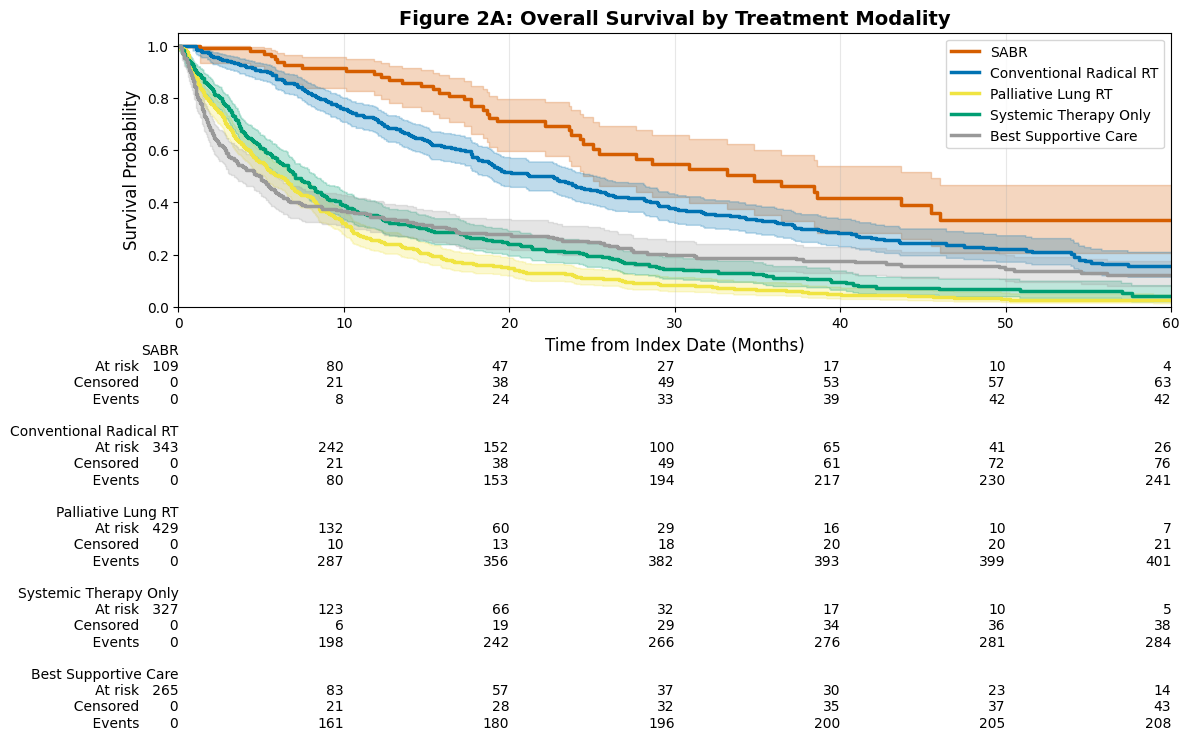


--- MEDIAN PFS (MONTHS) ---
SABR: 25.1 months
Conventional Radical RT: 12.8 months
Palliative Lung RT: 4.2 months
Systemic Therapy Only: 5.7 months
Best Supportive Care: 5.0 months


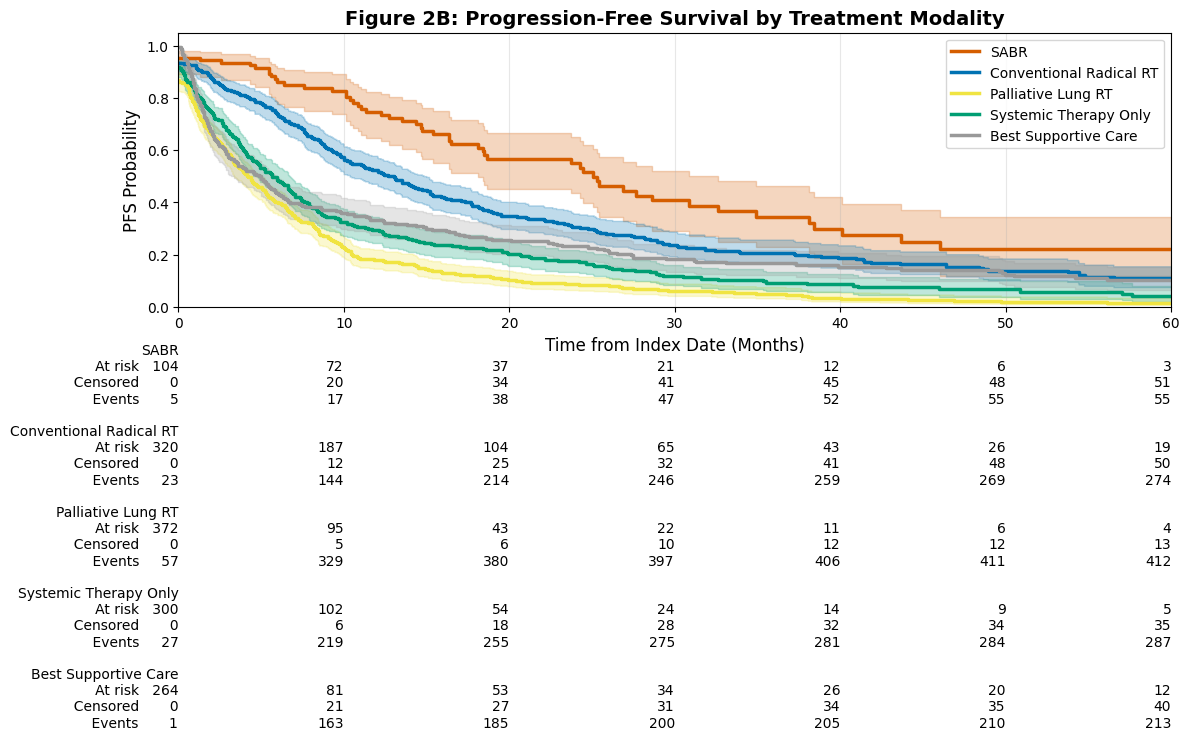

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

# --- 1. SOURCE CHECK ---
# We strictly use df_final, which is already filtered for NSCLC and cleaned.
if "df_final" not in globals() or not isinstance(df_final, pd.DataFrame):
    raise ValueError("df_final not found. Please run the 'NSCLC Filter' block first.")

print(f"Source: df_final (Verified NSCLC Cohort), N={len(df_final)}")

# --- 2. SETUP PLOTTING ---
kmf = KaplanMeierFitter()
cohorts = ["SABR", "Conventional Radical RT", "Palliative Lung RT", "Systemic Therapy Only", "Best Supportive Care"]
colors = {
    "SABR": "#D55E00",              # Vermillion
    "Conventional Radical RT": "#0072B2", # Blue
    "Palliative Lung RT": "#F0E442",      # Yellow
    "Systemic Therapy Only": "#009E73",   # Green
    "Best Supportive Care": "#999999",    # Grey
}

# --- 3. PLOT A: OVERALL SURVIVAL (OS) ---
plt.figure(figsize=(12, 8))
fitters_os = [] # Store fitters for the risk table
labels_os = []

print("\n--- MEDIAN OS (MONTHS) ---")
for cohort in cohorts:
    mask = df_final["Analysis_Cohort"] == cohort
    if mask.sum() == 0: continue

    # Fit KM
    kmf_temp = KaplanMeierFitter() # Use a fresh fitter for each curve storage
    kmf_temp.fit(
        durations=df_final.loc[mask, "OS_Months"],
        event_observed=df_final.loc[mask, "OS_Event"],
        label=f"{cohort}"
    )

    # Plot
    kmf_temp.plot_survival_function(linewidth=2.5, color=colors.get(cohort, "black"), ax=plt.gca())

    # Store for risk table
    fitters_os.append(kmf_temp)
    labels_os.append(cohort)

    # Print Median
    med = kmf_temp.median_survival_time_
    print(f"{cohort}: {med:.1f} months" if pd.notna(med) else f"{cohort}: Median not reached")

plt.title("Figure 2A: Overall Survival by Treatment Modality", fontsize=14, fontweight="bold")
plt.xlabel("Time from Index Date (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(0, 60)
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right")

# Add Risk Table (Publication Requirement)
add_at_risk_counts(*fitters_os, ax=plt.gca())

plt.tight_layout()
plt.show()

# --- 4. PLOT B: PROGRESSION-FREE SURVIVAL (PFS) ---
plt.figure(figsize=(12, 8))
fitters_pfs = []
labels_pfs = []

print("\n--- MEDIAN PFS (MONTHS) ---")
for cohort in cohorts:
    mask = df_final["Analysis_Cohort"] == cohort
    if mask.sum() == 0: continue

    # Use pre-cleaned columns
    d = df_final.loc[mask, "PFS_Months"]
    e = df_final.loc[mask, "PFS_Event"]

    # Safety: drop nan if any remain (though df_final should be clean)
    ok = d.notna() & e.notna()
    d = d[ok]; e = e[ok]
    if len(d) == 0: continue

    kmf_temp = KaplanMeierFitter()
    kmf_temp.fit(durations=d, event_observed=e, label=f"{cohort}")

    kmf_temp.plot_survival_function(linewidth=2.5, color=colors.get(cohort, "black"), ax=plt.gca())

    fitters_pfs.append(kmf_temp)
    labels_pfs.append(cohort)

    med = kmf_temp.median_survival_time_
    print(f"{cohort}: {med:.1f} months" if pd.notna(med) else f"{cohort}: Median not reached")

plt.title("Figure 2B: Progression-Free Survival by Treatment Modality", fontsize=14, fontweight="bold")
plt.xlabel("Time from Index Date (Months)", fontsize=12)
plt.ylabel("PFS Probability", fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(0, 60)
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right")

# Add Risk Table
add_at_risk_counts(*fitters_pfs, ax=plt.gca())

plt.tight_layout()
plt.show()

## 3. Sensitivity Analysis: Era-Matched Propensity Score

--- STARTING EARLY STAGE (I-II) MATCH ---
Source: df_final (N=1473)
Total Early Stage (I-II) Patients: 378
Matching on features: ['Age at primary Diagnosis', 'ECOG_score', 'Gender_Male', 'Morphology_Grouped_Large cell carcinoma', 'Morphology_Grouped_Mucinous adenocarcinoma', 'Morphology_Grouped_Other', 'Morphology_Grouped_Squamous cell carcinoma']
Matched Early-Stage Cohort Size: 182


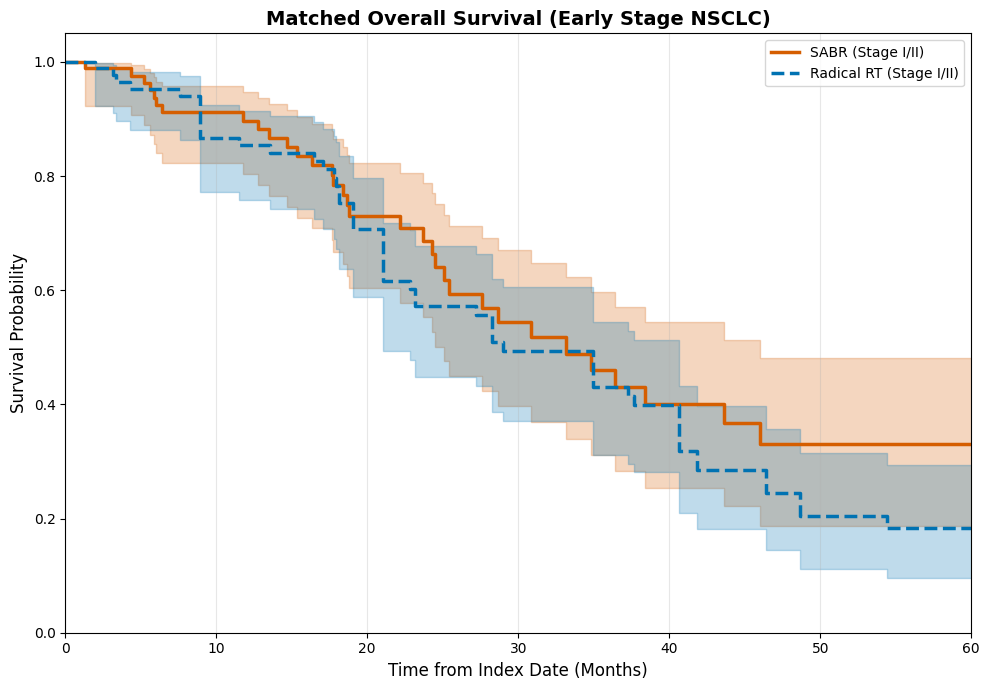


--- EARLY STAGE MATCHED COX MODEL ---


<lifelines.CoxPHFitter: fitted with 182 total observations, 88 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 182
number of events observed = 94
   partial log-likelihood = -383.14
         time fit was run = 2026-01-07 03:44:03 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Treatment -0.18      0.83      0.22           -0.61            0.24                0.54                1.27

           cmp to     z    p  -log2(p)
covariate                             
Treatment    0.00 -0.85 0.39      1.35
---
Concordance = 0.48
Partial AIC = 768.29
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

print("--- STARTING EARLY STAGE (I-II) MATCH ---")

# 1. SETUP: Use the Verified Cohort
if "df_final" in globals():
    target_df = df_final.copy()
    print(f"Source: df_final (N={len(target_df)})")
elif "df_master" in globals():
    # Fallback (Safety)
    sclc_mask = df_master["Morphology_Grouped"].astype(str).str.contains("Small cell", case=False, na=False)
    target_df = df_master.loc[~sclc_mask].copy()
    print(f"Source: df_master (filtered for NSCLC, N={len(target_df)})")
else:
    raise ValueError("No dataframe found. Run the NSCLC Filter block first.")

# 2. FILTER: EARLY STAGE ONLY
# This eliminates "Indication Bias" (SABR is for Stage I, Conventional often for Stage III)
early_stage_mask = target_df["Stage_Grouped_Final"].isin(["Stage I", "Stage II"])
df_early = target_df.loc[early_stage_mask].copy()

print(f"Total Early Stage (I-II) Patients: {len(df_early)}")

# Filter for relevant cohorts
match_cohorts = ["SABR", "Conventional Radical RT"]
df_psm = df_early[df_early["Analysis_Cohort"].isin(match_cohorts)].copy()

# 3. DEFINE MATCHING FEATURES
# We match on confounders that drive treatment selection
match_features = [
    "Age at primary Diagnosis",
    "Gender",
    "ECOG_score",
    "Morphology_Grouped"
]
# Drop rows missing these specific features
df_psm = df_psm.dropna(subset=match_features).copy()

# 4. ENCODE & PREPARE
df_psm_encoded = pd.get_dummies(
    df_psm,
    columns=["Gender", "Morphology_Grouped"],
    drop_first=True,
    dtype=int
)
df_psm_encoded["Treatment"] = np.where(df_psm_encoded["Analysis_Cohort"] == "SABR", 1, 0)

# Select numeric predictors dynamically
numeric_cols = df_psm_encoded.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = [
    "LINKAGE CODE", "Treatment", "OS_Months", "OS_Event",
    "PFS_Months", "PFS_Event", "Index_Date", "OS_End_Date", "PFS_End_Date",
    "First_Progression_Date", "Progression_Level", "Metastasis_Sites",
    "Met_Site_Count", "Oligometastatic_Flag", "BED10", "BED10_Group",
    "RT_Primary_Duration_days", "Dose_Gy", "Fractions",
    "Lung_RT_FLAG", "SABR_FLAG_Primary", "Chemo_FLAG", "SABR_History_Any",
    "Met_Site_Count_Calc", "Selection_Rank", "RT_Primary_BED10", "SABR_FLAG",
    "RT_Primary_Start", "Chemo_First_Start", "Primary diagnosis date",
    "Date of death", "Follow up status date", "best_ecog"
]
predictors = [c for c in numeric_cols if c not in exclude_cols]
print(f"Matching on features: {predictors}")

# 5. PROPENSITY SCORE & MATCHING
# Fit Logistic Regression (Treatment ~ Confounders)
logit = LogisticRegression(solver="liblinear", max_iter=2000)
logit.fit(df_psm_encoded[predictors], df_psm_encoded["Treatment"])
df_psm_encoded["Propensity_Score"] = logit.predict_proba(df_psm_encoded[predictors])[:, 1]

# Perform Nearest Neighbor Matching (1:1 with Replacement)
treated = df_psm_encoded[df_psm_encoded["Treatment"] == 1].copy()
control = df_psm_encoded[df_psm_encoded["Treatment"] == 0].copy()

if len(control) == 0:
    raise ValueError("No control patients (Conventional RT) found in Early Stage cohort!")

nbrs = NearestNeighbors(n_neighbors=1).fit(control[["Propensity_Score"]])
distances, indices = nbrs.kneighbors(treated[["Propensity_Score"]])

matched_controls = control.iloc[indices.flatten()].copy()
df_matched_early = pd.concat([treated, matched_controls], axis=0).copy()

print(f"Matched Early-Stage Cohort Size: {len(df_matched_early)}")

# 6. VISUALIZE SURVIVAL (Matched Cohort)
plt.figure(figsize=(10, 7))
kmf = KaplanMeierFitter()

# SABR Curve
mask1 = df_matched_early["Treatment"] == 1
kmf.fit(
    df_matched_early.loc[mask1, "OS_Months"],
    df_matched_early.loc[mask1, "OS_Event"],
    label="SABR (Stage I/II)"
)
kmf.plot_survival_function(color="#D55E00", linewidth=2.5)

# Conventional Curve
mask0 = df_matched_early["Treatment"] == 0
kmf.fit(
    df_matched_early.loc[mask0, "OS_Months"],
    df_matched_early.loc[mask0, "OS_Event"],
    label="Radical RT (Stage I/II)"
)
kmf.plot_survival_function(color="#0072B2", linewidth=2.5, linestyle="--")

plt.title("Matched Overall Survival (Early Stage NSCLC)", fontsize=14, fontweight="bold")
plt.xlabel("Time from Index Date (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(0, 60)
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 7. COX MODEL (With Robust Standard Errors)
print("\n--- EARLY STAGE MATCHED COX MODEL ---")
cph = CoxPHFitter()

# robust=True handles the paired/clustered nature of matched data
cph.fit(
    df_matched_early[["OS_Months", "OS_Event", "Treatment"]],
    duration_col="OS_Months",
    event_col="OS_Event",
    robust=True  # <--- CRITICAL FIX
)
cph.print_summary()

## 4. Mechanistic Validation: BED10 Dose Response

Dose Analysis Cohort: 881
BED10_Group breakdown:
BED10_Group
<60 Gy (Palliative)    481
60-100 Gy (Radical)    308
>100 Gy (Ablative)      92
Name: count, dtype: int64


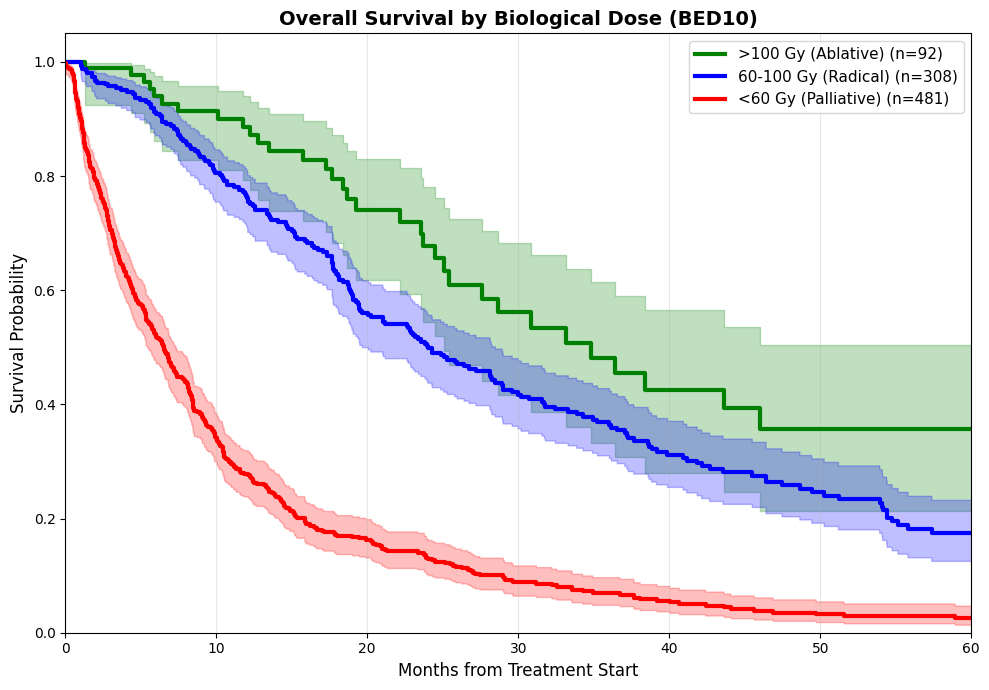

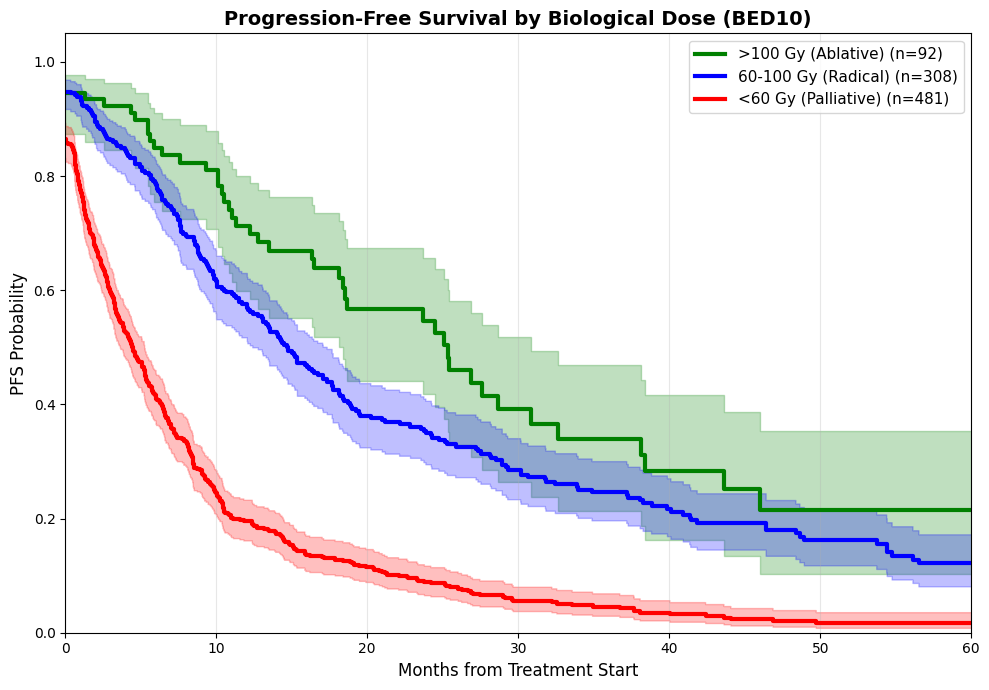


--- BED10 COX MODELS ---

>>> OS Model (Continuous BED):


<lifelines.CoxPHFitter: fitted with 730 total observations, 159 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Event'
      baseline estimation = breslow
   number of observations = 730
number of events observed = 571
   partial log-likelihood = -3117.94
         time fit was run = 2026-01-07 03:44:04 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
BED10                         -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
Age at primary Diagnosis       0.01      1.01      0.00            0.00            0.02                1.00                1.02
ECOG_score                     0.24      1.28      0.05            0.14            0.34                1.16                1.41
Stage_Grouped_Final_Stage II  -0.05      0.95      0.19           -0.41            0.32                0.66                1.37
Stage_Grouped_Final_Stage III  0.09      1.10      0.14           -0.17            0.36                0.84                1.43
Stage_Grouped_Final_Stage IV   0.24      1.28      0.15           -0.04            0.53                0.96                1.70

                               cmp to      z      p  -log2(p)
covariate                                                    
BED10                            0.00 -11.72 <0.005    102.98
Age at primary Diagnosis         0.00   2.51   0.01      6.36
ECOG_score                       0.00   4.80 <0.005     19.26
Stage_Grouped_Final_Stage II     0.00  -0.25   0.80      0.32
Stage_Grouped_Final_Stage III    0.00   0.68   0.50      1.01
Stage_Grouped_Final_Stage IV     0.00   1.68   0.09      3.42
---
Concordance = 0.72
Partial AIC = 6247.88
log-likelihood ratio test = 258.44 on 6 df
-log2(p) of ll-ratio test = 173.37


>>> OS Model (Continuous BED):


<lifelines.CoxPHFitter: fitted with 730 total observations, 159 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Event'
      baseline estimation = breslow
   number of observations = 730
number of events observed = 571
   partial log-likelihood = -3117.94
         time fit was run = 2026-01-07 03:44:04 UTC

---
                               coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%      p
covariate                                                                                   
BED10                         -0.02      0.98                0.97                0.98 <0.005
Age at primary Diagnosis       0.01      1.01                1.00                1.02   0.01
ECOG_score                     0.24      1.28                1.16                1.41 <0.005
Stage_Grouped_Final_Stage II  -0.05      0.95                0.66                1.37   0.80
Stage_Grouped_Final_Stage III  0.09      1.10                0.84                1.43   0.50
Stage_Grouped_Final_Stage IV   0.24      1.28                0.96                1.70   0.09
---
Concordance = 0.72
Partial AIC = 6247.88
log-likelihood ratio test = 258.44 on 6 df
-log2(p) of ll-ratio test = 173.37


>>> PFS Model (Continuous BED):


<lifelines.CoxPHFitter: fitted with 730 total observations, 115 right-censored observations>
             duration col = 'PFS_Months'
                event col = 'PFS_Event'
      baseline estimation = breslow
   number of observations = 730
number of events observed = 615
   partial log-likelihood = -3414.16
         time fit was run = 2026-01-07 03:44:04 UTC

---
                               coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%      p
covariate                                                                                   
BED10                         -0.02      0.98                0.98                0.99 <0.005
Age at primary Diagnosis      -0.00      1.00                0.99                1.01   0.90
ECOG_score                     0.22      1.25                1.13                1.37 <0.005
Stage_Grouped_Final_Stage II   0.41      1.51                1.07                2.13   0.02
Stage_Grouped_Final_Stage III  0.27      1.31                1.01                1.70   0.04
Stage_Grouped_Final_Stage IV   0.50      1.66                1.25                2.20 <0.005
---
Concordance = 0.68
Partial AIC = 6840.32
log-likelihood ratio test = 195.78 on 6 df
-log2(p) of ll-ratio test = 128.97

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# --- SOURCE: df_master only ---
if "df_master" not in globals() or not isinstance(df_master, pd.DataFrame):
    raise ValueError("df_master not found. Build df_master first.")

df_raw = df_master.copy()
sclc_mask = df_raw["Morphology_Grouped"].astype(str).str.contains("Small cell", case=False, na=False)
df_nsclc = df_raw.loc[~sclc_mask].copy()

# --- Coerce key survival + BED fields (registry reality) ---
for c in ["OS_Months", "PFS_Months", "BED10"]:
    if c in df_nsclc.columns:
        df_nsclc[c] = pd.to_numeric(df_nsclc[c], errors="coerce")
for c in ["OS_Event", "PFS_Event"]:
    if c in df_nsclc.columns:
        df_nsclc[c] = pd.to_numeric(df_nsclc[c], errors="coerce")

# ======================================================================
# PREPARE DATA (LUNG RT ONLY) + ensure BED10_Group exists
# ======================================================================
bed_df = df_nsclc[df_nsclc["Analysis_Cohort"].isin(
    ["SABR", "Conventional Radical RT", "Palliative Lung RT"]
)].copy()

bed_df = bed_df.dropna(subset=["BED10"]).copy()
bed_df = bed_df.loc[bed_df["BED10"] >= 0].copy()

# Define BED10 groups (uses your cutpoints)
bed_df["BED10_Group"] = pd.cut(
    bed_df["BED10"],
    bins=[-np.inf, 60, 100, np.inf],
    labels=["<60 Gy (Palliative)", "60-100 Gy (Radical)", ">100 Gy (Ablative)"],
    right=True,
    include_lowest=True
)

print(f"Dose Analysis Cohort: {len(bed_df)}")
print("BED10_Group breakdown:")
print(bed_df["BED10_Group"].value_counts(dropna=False))

kmf = KaplanMeierFitter()
groups = [">100 Gy (Ablative)", "60-100 Gy (Radical)", "<60 Gy (Palliative)"]
bed_colors = {">100 Gy (Ablative)": "green", "60-100 Gy (Radical)": "blue", "<60 Gy (Palliative)": "red"}

# ======================================================================
# FIGURE 3A: OS (drop NaNs per group)
# ======================================================================
plt.figure(figsize=(10, 7))
for group in groups:
    g = bed_df.loc[bed_df["BED10_Group"] == group, ["OS_Months", "OS_Event"]].copy()
    g = g.dropna()
    g = g.loc[g["OS_Months"] >= 0]
    if len(g) == 0:
        continue

    kmf.fit(durations=g["OS_Months"].astype(float),
            event_observed=g["OS_Event"].astype(int),
            label=f"{group} (n={len(g)})")
    kmf.plot_survival_function(linewidth=3, color=bed_colors.get(group, "grey"))

plt.title("Overall Survival by Biological Dose (BED10)", fontsize=14, fontweight="bold")
plt.xlabel("Months from Treatment Start", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.ylim(0, 1.05); plt.xlim(0, 60)
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right", fontsize=11)
plt.tight_layout()
plt.show()

# ======================================================================
# FIGURE 3B: PFS (drop NaNs per group)
# ======================================================================
plt.figure(figsize=(10, 7))
for group in groups:
    g = bed_df.loc[bed_df["BED10_Group"] == group, ["PFS_Months", "PFS_Event"]].copy()
    g = g.dropna()
    g = g.loc[g["PFS_Months"] >= 0]
    if len(g) == 0:
        continue

    kmf.fit(durations=g["PFS_Months"].astype(float),
            event_observed=g["PFS_Event"].astype(int),
            label=f"{group} (n={len(g)})")
    kmf.plot_survival_function(linewidth=3, color=bed_colors.get(group, "grey"))

plt.title("Progression-Free Survival by Biological Dose (BED10)", fontsize=14, fontweight="bold")
plt.xlabel("Months from Treatment Start", fontsize=12)
plt.ylabel("PFS Probability", fontsize=12)
plt.ylim(0, 1.05); plt.xlim(0, 60)
plt.grid(axis="x", alpha=0.3)
plt.legend(loc="upper right", fontsize=11)
plt.tight_layout()
plt.show()

# ======================================================================
# COX MODELS (remove NaNs/infs across ALL covariates used)
# ======================================================================
print("\n--- BED10 COX MODELS ---")
cox_cols = ["OS_Months", "OS_Event", "PFS_Months", "PFS_Event", "BED10",
            "Age at primary Diagnosis", "ECOG_score", "Stage_Grouped_Final"]

df_bed_cox = bed_df[cox_cols].copy()

# coerce numeric
for c in ["OS_Months", "PFS_Months", "BED10", "Age at primary Diagnosis", "ECOG_score"]:
    df_bed_cox[c] = pd.to_numeric(df_bed_cox[c], errors="coerce")
for c in ["OS_Event", "PFS_Event"]:
    df_bed_cox[c] = pd.to_numeric(df_bed_cox[c], errors="coerce")

# drop NaNs needed for Cox (lifelines strict)
df_bed_cox = df_bed_cox.replace([np.inf, -np.inf], np.nan).dropna().copy()

# stage dummies
df_bed_cox["Stage_Grouped_Final"] = df_bed_cox["Stage_Grouped_Final"].astype(str).str.strip()
df_bed_cox = pd.get_dummies(df_bed_cox, columns=["Stage_Grouped_Final"], drop_first=True)

print("\n>>> OS Model (Continuous BED):")
cph_os = CoxPHFitter()
cph_os.fit(df_bed_cox.drop(columns=["PFS_Months", "PFS_Event"]),
           duration_col="OS_Months", event_col="OS_Event")
cph_os.print_summary()

print("\n>>> OS Model (Continuous BED):")
cph_os = CoxPHFitter()
# Fit model
cph_os.fit(df_bed_cox.drop(columns=["PFS_Months", "PFS_Event"]),
           duration_col="OS_Months", event_col="OS_Event")

# Print just the key stats (HR, CI, p-value)
cph_os.print_summary(columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"])

print("\n>>> PFS Model (Continuous BED):")
cph_pfs = CoxPHFitter()
cph_pfs.fit(df_bed_cox.drop(columns=["OS_Months", "OS_Event"]),
            duration_col="PFS_Months", event_col="PFS_Event")

cph_pfs.print_summary(columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"])

## S1. Multivariable Analysis: Cox Models & Forest Plots

Patients included in Models: 730

>>> A. COX MODEL: OVERALL SURVIVAL (OS)


<lifelines.CoxPHFitter: fitted with 730 total observations, 159 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 730
number of events observed = 571
   partial log-likelihood = -3143.22
         time fit was run = 2026-01-07 03:44:05 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
Age at primary Diagnosis            0.00      1.00      0.00           -0.01            0.01                0.99                1.01
ECOG_score                          0.19      1.21      0.05            0.10            0.29                1.11                1.33
Chemo_FLAG                         -0.22      0.80      0.09           -0.39           -0.04                0.67                0.96
Stage_Grouped_Final_Stage II        0.15      1.16      0.16           -0.17            0.47                0.84                1.60
Stage_Grouped_Final_Stage III       0.27      1.31      0.12            0.04            0.50                1.04                1.64
Stage_Grouped_Final_Stage IV        0.46      1.58      0.11            0.24            0.68                1.27                1.98
Analysis_Cohort_Palliative Lung RT  0.82      2.26      0.09            0.64            1.00                1.89                2.71
Analysis_Cohort_SABR               -0.38      0.68      0.15           -0.68           -0.08                0.51                0.92
Gender_Male                         0.23      1.26      0.08            0.07            0.40                1.07                1.49

                                    cmp to     z      p  -log2(p)
covariate                                                        
Age at primary Diagnosis              0.00  0.68   0.49      1.02
ECOG_score                            0.00  4.09 <0.005     14.51
Chemo_FLAG                            0.00 -2.44   0.01      6.08
Stage_Grouped_Final_Stage II          0.00  0.91   0.36      1.45
Stage_Grouped_Final_Stage III         0.00  2.31   0.02      5.60
Stage_Grouped_Final_Stage IV          0.00  4.03 <0.005     14.11
Analysis_Cohort_Palliative Lung RT    0.00  8.97 <0.005     61.54
Analysis_Cohort_SABR                  0.00 -2.52   0.01      6.40
Gender_Male                           0.00  2.80   0.01      7.63
---
Concordance = 0.71
Partial AIC = 6304.44
log-likelihood ratio test = 207.87 on 9 df
-log2(p) of ll-ratio test = 129.99

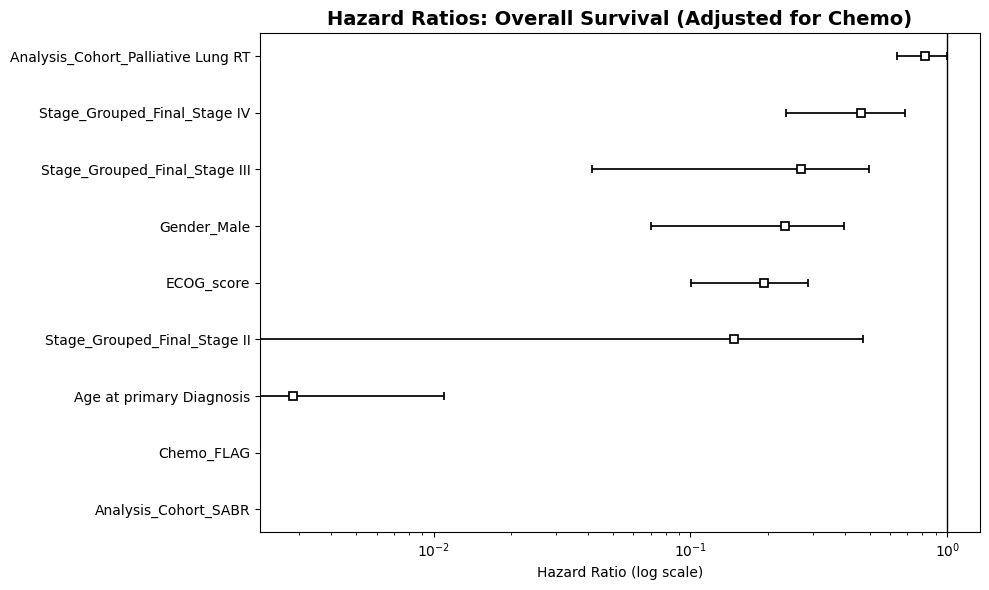


>>> B. COX MODEL: PROGRESSION-FREE SURVIVAL (PFS)


<lifelines.CoxPHFitter: fitted with 730 total observations, 115 right-censored observations>
             duration col = 'PFS_Months'
                event col = 'PFS_Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 730
number of events observed = 615
   partial log-likelihood = -3431.72
         time fit was run = 2026-01-07 03:44:05 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
Age at primary Diagnosis           -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
ECOG_score                          0.18      1.20      0.05            0.09            0.27                1.10                1.32
Chemo_FLAG                         -0.07      0.93      0.09           -0.24            0.10                0.78                1.11
Stage_Grouped_Final_Stage II        0.38      1.47      0.16            0.08            0.69                1.08                2.00
Stage_Grouped_Final_Stage III       0.29      1.33      0.11            0.06            0.51                1.06                1.67
Stage_Grouped_Final_Stage IV        0.54      1.72      0.11            0.32            0.77                1.38                2.16
Analysis_Cohort_Palliative Lung RT  0.57      1.76      0.09            0.39            0.74                1.48                2.10
Analysis_Cohort_SABR               -0.32      0.73      0.14           -0.60           -0.03                0.55                0.97
Gender_Male                         0.08      1.08      0.08           -0.08            0.24                0.93                1.27

                                    cmp to     z      p  -log2(p)
covariate                                                        
Age at primary Diagnosis              0.00 -0.99   0.32      1.64
ECOG_score                            0.00  4.03 <0.005     14.15
Chemo_FLAG                            0.00 -0.80   0.43      1.23
Stage_Grouped_Final_Stage II          0.00  2.45   0.01      6.11
Stage_Grouped_Final_Stage III         0.00  2.49   0.01      6.30
Stage_Grouped_Final_Stage IV          0.00  4.77 <0.005     19.07
Analysis_Cohort_Palliative Lung RT    0.00  6.27 <0.005     31.39
Analysis_Cohort_SABR                  0.00 -2.20   0.03      5.17
Gender_Male                           0.00  1.01   0.31      1.68
---
Concordance = 0.67
Partial AIC = 6881.44
log-likelihood ratio test = 160.65 on 9 df
-log2(p) of ll-ratio test = 97.22

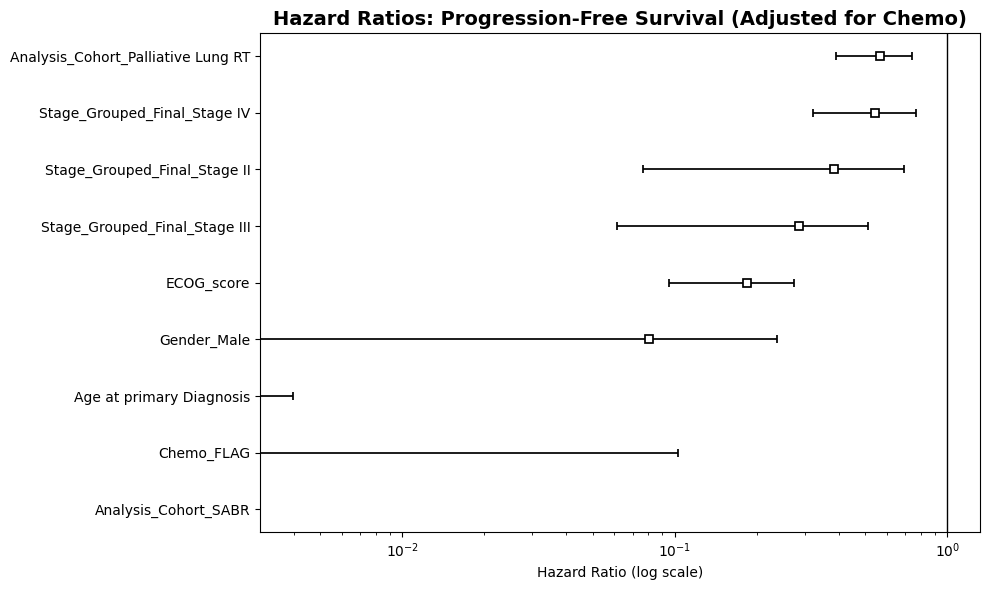

In [ ]:
from lifelines import CoxPHFitter
import pandas as pd
import matplotlib.pyplot as plt


# --- SAFETY HEADER: REQUIRE IN-MEMORY DATA ---
if 'df_nsclc' not in locals():
    raise ValueError("df_nsclc not found in memory. Do not fall back to CSV.")

# 1. PREPARE DATA
model_cols = [
    'OS_Months', 'OS_Event',
    'PFS_Months', 'PFS_Event',
    'Analysis_Cohort',
    'Age at primary Diagnosis',
    'ECOG_score',
    'Stage_Grouped_Final',
    'Gender',
    'Chemo_FLAG'
]

comparison_groups = ['SABR', 'Conventional Radical RT', 'Palliative Lung RT']

df_cox = df_nsclc.loc[
    df_nsclc['Analysis_Cohort'].isin(comparison_groups),
    model_cols
].dropna()

print(f"Patients included in Models: {len(df_cox)}")

# 2. ENCODE VARIABLES
# FIX: drop_first=True prevents dummy-variable trap
df_cox_encoded = pd.get_dummies(
    df_cox,
    columns=['Stage_Grouped_Final', 'Analysis_Cohort', 'Gender'],
    drop_first=True
)

# ------------------------------------------------------
# MODEL A: OVERALL SURVIVAL (OS)
# ------------------------------------------------------
print("\n>>> A. COX MODEL: OVERALL SURVIVAL (OS)")
cph_os = CoxPHFitter(penalizer=0.1)

os_data = df_cox_encoded.drop(columns=['PFS_Months', 'PFS_Event'])
cph_os.fit(os_data, duration_col='OS_Months', event_col='OS_Event')
cph_os.print_summary()

# Forest Plot (OS) — DISPLAY ONLY
plt.figure(figsize=(10, 6))
ax = cph_os.plot()
ax.axvline(1.0, color='black', linewidth=1)
ax.set_xscale('log')
plt.title("Hazard Ratios: Overall Survival (Adjusted for Chemo)", fontsize=14, fontweight='bold')
plt.xlabel("Hazard Ratio (log scale)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# MODEL B: PROGRESSION-FREE SURVIVAL (PFS)
# ------------------------------------------------------
print("\n>>> B. COX MODEL: PROGRESSION-FREE SURVIVAL (PFS)")
cph_pfs = CoxPHFitter(penalizer=0.1)

pfs_data = df_cox_encoded.drop(columns=['OS_Months', 'OS_Event'])
cph_pfs.fit(pfs_data, duration_col='PFS_Months', event_col='PFS_Event')
cph_pfs.print_summary()

# Forest Plot (PFS) — DISPLAY ONLY
plt.figure(figsize=(10, 6))
ax = cph_pfs.plot()
ax.axvline(1.0, color='black', linewidth=1)
ax.set_xscale('log')
plt.title("Hazard Ratios: Progression-Free Survival (Adjusted for Chemo)", fontsize=14, fontweight='bold')
plt.xlabel("Hazard Ratio (log scale)")
plt.tight_layout()
plt.show()


## 5. Biological Validation: Failure Patterns

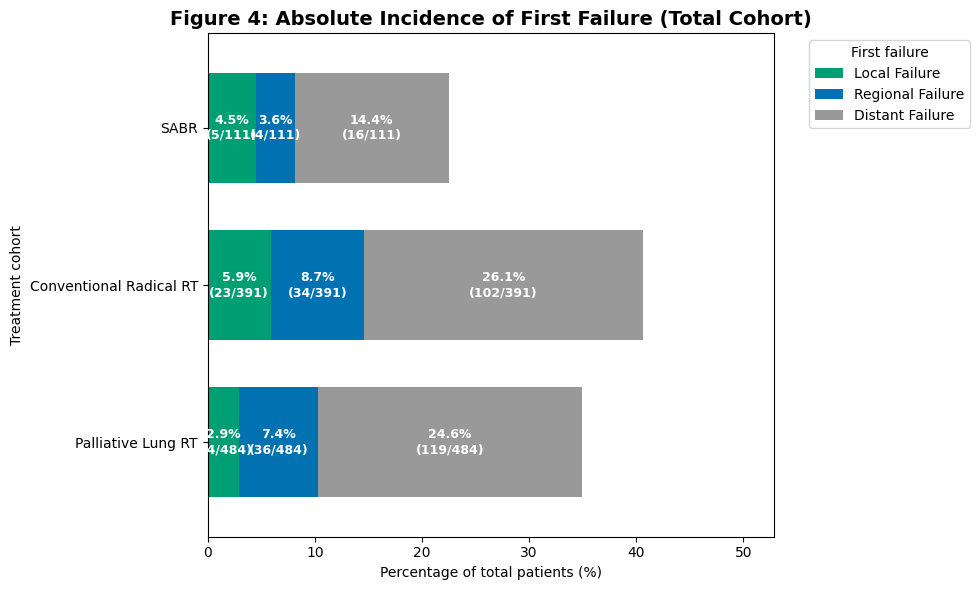


--- ABSOLUTE FIRST-FAILURE COUNTS & RATES ---
                         Total N  n_Local Failure  n_Regional Failure  \
Analysis_Cohort                                                         
SABR                         111                5                   4   
Conventional Radical RT      391               23                  34   
Palliative Lung RT           484               14                  36   

                         n_Distant Failure  %_Local Failure  \
Analysis_Cohort                                               
SABR                                    16         4.504505   
Conventional Radical RT                102         5.882353   
Palliative Lung RT                     119         2.892562   

                         %_Regional Failure  %_Distant Failure  
Analysis_Cohort                                                 
SABR                               3.603604          14.414414  
Conventional Radical RT            8.695652          26.086957  
Palliative 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- SAFETY HEADER (single source of truth, no saving) ---
if "df_master" in globals() and isinstance(df_master, pd.DataFrame):
    df_src = df_master.copy()
elif "df_nsclc" in locals() and isinstance(df_nsclc, pd.DataFrame):
    df_src = df_nsclc.copy()
else:
    df_src = pd.read_csv("Final_Paper_Dataset_N1881.csv")

req = ["Analysis_Cohort", "Progression_Level", "PFS_Event"]
missing = [c for c in req if c not in df_src.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Normalize messy registry strings/events
df_src["Analysis_Cohort"] = df_src["Analysis_Cohort"].astype(str).str.strip()
df_src["Progression_Level"] = df_src["Progression_Level"].astype(str).str.strip()
df_src["PFS_Event"] = pd.to_numeric(df_src["PFS_Event"], errors="coerce").fillna(0).astype(int)

# Target cohorts (desired display order: SABR top, then conventional, then palliative)
cohorts = ["SABR", "Conventional Radical RT", "Palliative Lung RT"]
df_analysis = df_src.loc[df_src["Analysis_Cohort"].isin(cohorts)].copy()

# Denominators: total treated per cohort (absolute incidence)
denom = (
    df_analysis.groupby("Analysis_Cohort")
    .size()
    .reindex(cohorts)
    .fillna(0)
    .astype(int)
)

# Numerators: first-failure category counts (use PFS_Event==1, exclude "No Progression")
fail_types = ["Local Failure", "Regional Failure", "Distant Failure"]
df_fail = df_analysis.loc[
    (df_analysis["PFS_Event"] == 1) &
    (df_analysis["Progression_Level"].isin(fail_types))
].copy()

num = (
    df_fail.groupby(["Analysis_Cohort", "Progression_Level"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=cohorts, columns=fail_types, fill_value=0)
)

# Absolute % for each failure type
abs_pct = (num.div(denom.replace(0, np.nan), axis=0) * 100).fillna(0.0)

# Muted palette aligned with your PFS figure style (no loud red/green/blue trio)
seg_colors = {
    "Local Failure":   "#009E73",  # muted green
    "Regional Failure":"#0072B2",  # muted blue
    "Distant Failure": "#999999",  # grey
}

# --- PLOT: stacked horizontal absolute incidence ---
ax = abs_pct.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=[seg_colors[c] for c in fail_types],
    width=0.7
)

plt.title("Figure 4: Absolute Incidence of First Failure (Total Cohort)", fontsize=14, fontweight="bold")
plt.xlabel("Percentage of total patients (%)")
plt.ylabel("Treatment cohort")
plt.legend(title="First failure", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ensure SABR appears at the top (matplotlib barh places first row at bottom by default)
ax.invert_yaxis()

# axis max with headroom
xmax = float(abs_pct.sum(axis=1).max()) if len(abs_pct) else 0.0
plt.xlim(0, max(10, xmax * 1.3))

# Segment labels (only if non-trivial)
for i, cohort in enumerate(abs_pct.index):
    cum = 0.0
    for ft in fail_types:
        pct = float(abs_pct.loc[cohort, ft])
        n = int(num.loc[cohort, ft])
        N = int(denom.loc[cohort])
        if pct >= 1.0:
            ax.text(
                cum + pct / 2, i,
                f"{pct:.1f}%\n({n}/{N})",
                va="center", ha="center",
                color="white", fontweight="bold", fontsize=9
            )
        cum += pct

plt.tight_layout()
plt.show()

print("\n--- ABSOLUTE FIRST-FAILURE COUNTS & RATES ---")
out = pd.concat(
    [denom.rename("Total N"), num.add_prefix("n_"), abs_pct.add_prefix("%_")],
    axis=1
).reindex(cohorts)
print(out)


--- STEP 1: COHORT PREPARATION ---
Original Cohort N: 213
Treatment Group (SABR): 91
Control Group (Radical): 122
Final Matching Variables (All Numeric): ['Age at primary Diagnosis', 'Gender_Male', 'ECOG_score_1', 'ECOG_score_2', 'ECOG_score_3', 'ECOG_score_99']

--- STEP 2: GENERATING MATCHES ---
Matched Cohort N: 182 (1:1 Ratio)


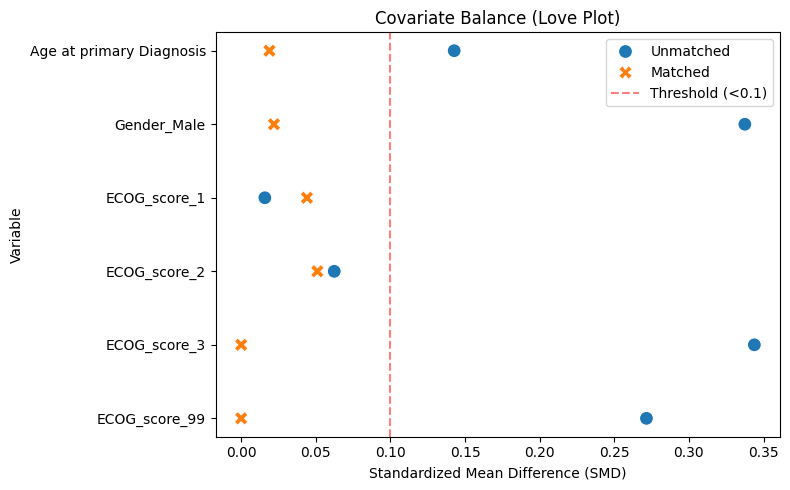


--- STEP 3: SURVIVAL ANALYSIS (MATCHED) ---


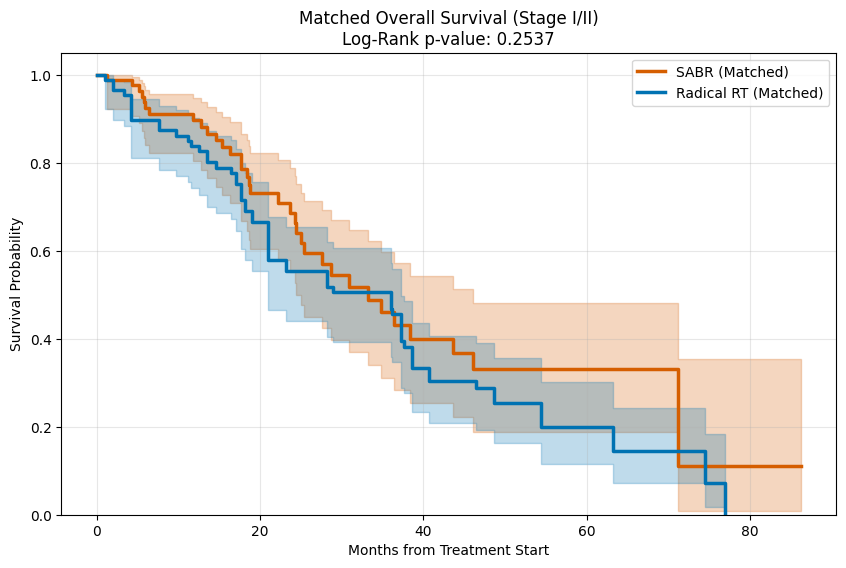


--- COX PROPORTIONAL HAZARDS MODEL ---


<lifelines.CoxPHFitter: fitted with 182 total observations, 77 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 182
number of events observed = 105
   partial log-likelihood = -420.02
         time fit was run = 2026-01-07 03:44:07 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
Treatment                -0.22      0.80      0.22           -0.66            0.22                0.52                1.24
Age at primary Diagnosis  0.04      1.04      0.01            0.01            0.06                1.01                1.06
Gender_Male               0.44      1.56      0.23            0.00            0.89                1.00                2.42
ECOG_score_1              0.76      2.15      0.33            0.11            1.42                1.12                4.12
ECOG_score_2              1.08      2.93      0.33            0.42            1.73                1.52                5.66
ECOG_score_3              1.57      4.81      0.37            0.85            2.29                2.35                9.86
ECOG_score_99             0.81      2.24      0.93           -1.02            2.63                0.36               13.84

                          cmp to     z      p  -log2(p)
covariate                                              
Treatment                   0.00 -0.99   0.32      1.64
Age at primary Diagnosis    0.00  2.57   0.01      6.63
Gender_Male                 0.00  1.97   0.05      4.34
ECOG_score_1                0.00  2.30   0.02      5.53
ECOG_score_2                0.00  3.21 <0.005      9.57
ECOG_score_3                0.00  4.29 <0.005     15.78
ECOG_score_99               0.00  0.87   0.39      1.37
---
Concordance = 0.55
Partial AIC = 854.05
log-likelihood ratio test = 36.78 on 7 df
-log2(p) of ll-ratio test = 17.56

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from lifelines.statistics import logrank_test

# ==============================================================================
# 1. SETUP: COHORT PREPARATION
# ==============================================================================
print("--- STEP 1: COHORT PREPARATION ---")

# A. Strict Stage Filter (Stage I/II only)
stage_mask = df_final["Stage_Grouped_Final"].isin(["Stage I", "Stage II"])
cohort_mask = df_final["Analysis_Cohort"].isin(["SABR", "Conventional Radical RT"])

df_study = df_final.loc[stage_mask & cohort_mask].copy()

# B. Encode Treatment (1 = SABR, 0 = Radical)
df_study["Treatment"] = np.where(df_study["Analysis_Cohort"] == "SABR", 1, 0)

# C. Define EXACTLY which variables to match on (The Whitelist)
# We only want baseline clinical confounders.
# We explicitly EXCLUDE post-treatment outcomes and text descriptions.
match_vars_base = ["Age at primary Diagnosis", "ECOG_score", "Gender"]

# Handle missing data only for these specific variables
df_study_clean = df_study.dropna(subset=match_vars_base).copy()

# D. Encode Categorical Variables
# We select ONLY the relevant columns to avoid pulling in "Region of birth" or "RT Technique"
cols_to_keep = match_vars_base + ["Treatment", "OS_Months", "OS_Event", "Analysis_Cohort"]
df_model = df_study_clean[cols_to_keep].copy()

# One-hot encode Gender and ECOG
df_model = pd.get_dummies(df_model, columns=["Gender", "ECOG_score"], drop_first=True)

# Define the final list of numeric predictors for the model
confounders = [c for c in df_model.columns if c not in
               ["Treatment", "OS_Months", "OS_Event", "Analysis_Cohort"]]

print(f"Original Cohort N: {len(df_study_clean)}")
print(f"Treatment Group (SABR): {df_study_clean['Treatment'].sum()}")
print(f"Control Group (Radical): {len(df_study_clean) - df_study_clean['Treatment'].sum()}")
print(f"Final Matching Variables (All Numeric): {confounders}")

# ==============================================================================
# 2. PROPENSITY SCORE MATCHING (PSM)
# ==============================================================================
print("\n--- STEP 2: GENERATING MATCHES ---")

# A. Calculate Propensity Scores
# Now safe because 'confounders' only contains numbers (Age) and 0/1 dummies
ps_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
ps_model.fit(df_model[confounders], df_model["Treatment"])
df_model["ps_score"] = ps_model.predict_proba(df_model[confounders])[:, 1]

# B. Nearest Neighbor Matching (1:1 without replacement)
treated = df_model[df_model["Treatment"] == 1]
control = df_model[df_model["Treatment"] == 0]

if len(control) == 0:
    raise ValueError("No Control patients available for matching.")

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[["ps_score"]])
distances, indices = nbrs.kneighbors(treated[["ps_score"]])

# Select matched controls
matched_control_indices = indices.flatten()
matched_controls = control.iloc[matched_control_indices]

# Final Matched Cohort
df_matched = pd.concat([treated, matched_controls])

print(f"Matched Cohort N: {len(df_matched)} (1:1 Ratio)")

# ==============================================================================
# 3. BALANCE CHECK (LOVE PLOT)
# ==============================================================================
def calculate_smd(df, variable, treatment_col="Treatment"):
    t = df[df[treatment_col] == 1][variable].mean()
    c = df[df[treatment_col] == 0][variable].mean()
    var_t = df[df[treatment_col] == 1][variable].var()
    var_c = df[df[treatment_col] == 0][variable].var()

    pooled_sd = np.sqrt((var_t + var_c) / 2)
    if pooled_sd == 0: return 0
    return (t - c) / pooled_sd

smd_data = []
for var in confounders:
    smd_pre = calculate_smd(df_model, var)
    smd_post = calculate_smd(df_matched, var)
    smd_data.append({"Variable": var, "SMD": abs(smd_pre), "Type": "Unmatched"})
    smd_data.append({"Variable": var, "SMD": abs(smd_post), "Type": "Matched"})

df_smd = pd.DataFrame(smd_data)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_smd, x="SMD", y="Variable", hue="Type", style="Type", s=100)
plt.axvline(x=0.1, color='r', linestyle='--', alpha=0.5, label="Threshold (<0.1)")
plt.title("Covariate Balance (Love Plot)")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. SURVIVAL ANALYSIS (MATCHED)
# ==============================================================================
print("\n--- STEP 3: SURVIVAL ANALYSIS (MATCHED) ---")

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# SABR
mask_sabr = df_matched["Treatment"] == 1
kmf.fit(df_matched.loc[mask_sabr, "OS_Months"], df_matched.loc[mask_sabr, "OS_Event"], label="SABR (Matched)")
kmf.plot_survival_function(color="#D55E00", linewidth=2.5, ci_show=True)

# Radical
mask_rad = df_matched["Treatment"] == 0
kmf.fit(df_matched.loc[mask_rad, "OS_Months"], df_matched.loc[mask_rad, "OS_Event"], label="Radical RT (Matched)")
kmf.plot_survival_function(color="#0072B2", linewidth=2.5, ci_show=True)

# Log-Rank
results = logrank_test(
    df_matched.loc[mask_sabr, "OS_Months"], df_matched.loc[mask_rad, "OS_Months"],
    df_matched.loc[mask_sabr, "OS_Event"], df_matched.loc[mask_rad, "OS_Event"]
)

plt.title(f"Matched Overall Survival (Stage I/II)\nLog-Rank p-value: {results.p_value:.4f}")
plt.xlabel("Months from Treatment Start")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

# ==============================================================================
# 5. COX MODEL (DOUBLY ROBUST)
# ==============================================================================
print("\n--- COX PROPORTIONAL HAZARDS MODEL ---")
cph = CoxPHFitter()
cph.fit(df_matched[["OS_Months", "OS_Event", "Treatment"] + confounders],
        duration_col="OS_Months", event_col="OS_Event", robust=True)
cph.print_summary()

--- DIAGNOSTICS MODULE: INITIATING ---
Diagnostic Sub-Cohort N: 452

--- 1. INFORMATION LOSS (BED10 OVERLAP) ---
>>> BED10 Statistics by Assigned Category:
                         count   mean   std   min    25%    50%    75%    max
Analysis_Cohort                                                              
Conventional Radical RT  343.0   70.3   9.2  50.0   70.1   72.0   72.0   84.3
SABR                     109.0  108.8  11.8  79.3  105.6  105.6  105.7  151.2

>>> 'Borderline' Regimens (BED10 60-100 Gy): 309 (68.4%)
    (This quantifies the 'Information Loss' where categorization is arbitrary)


/tmp/ipython-input-2059827519.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


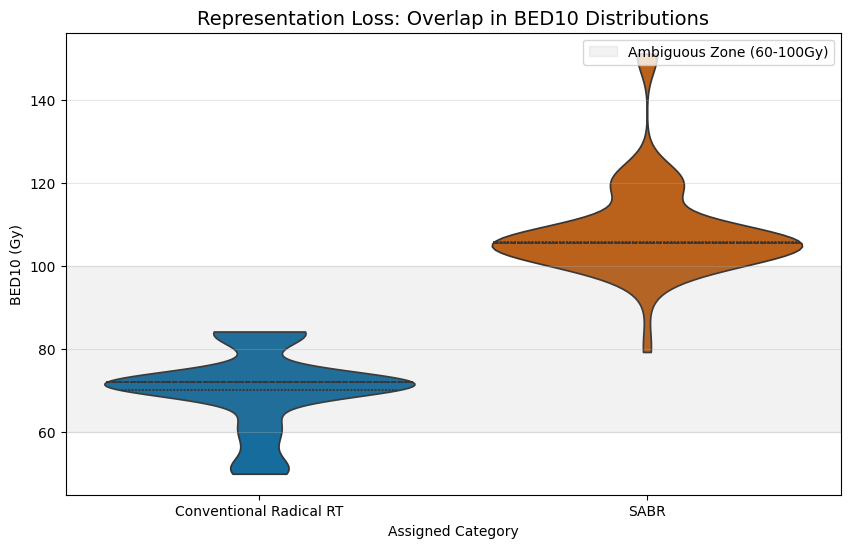


--- 2. NON-LINEARITY CHECK (Continuous Representation) ---
Linear Model AIC: 3078.3
Polynomial Model AIC: 3076.3
Non-linear term p-value: 0.0321
RESULT: Significant Non-Linearity detected (p < 0.05). Categorization or Splines recommended.

--- 4. PROPORTIONAL HAZARDS CHECK (Schoenfeld Residuals) ---
Checking PH assumption on Linear BED10 Model...
Error running PH check: Cannot cast object dtype to float64

--- 3. SENSITIVITY ANALYSIS (Arbitrary Cutoffs) ---
SEARCHING FOR DOSE/FRACTION COLUMNS...
Potential Fraction Cols: []
Potential Dose Cols:     ['Morphology_Grouped']

⚠️ SKIPPING SENSITIVITY ANALYSIS: Could not automatically identify Dose/Fraction columns.
ACTION REQUIRED: Look at the 'Potential Cols' printed above.
Then update the 'col_fx' and 'col_gy' variables in the script with the correct names.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# --- SAFETY CHECK ---
if "df_final" not in globals():
    raise ValueError("df_final not found. Please run the previous 'Clinical Rules' analysis first.")

print("--- DIAGNOSTICS MODULE: INITIATING ---")

# Filter for Curative Cohorts (SABR vs Radical) for direct comparison
mask_curative = df_final["Analysis_Cohort"].isin(["SABR", "Conventional Radical RT"])
df_diag = df_final.loc[mask_curative].copy()
print(f"Diagnostic Sub-Cohort N: {len(df_diag)}")

# ==============================================================================
# 1. CONCORDANCE & INFORMATION LOSS (BED10 DISTRIBUTIONS)
# ==============================================================================
print("\n--- 1. INFORMATION LOSS (BED10 OVERLAP) ---")

# A. Descriptive Stats
print(">>> BED10 Statistics by Assigned Category:")
stats = df_diag.groupby("Analysis_Cohort")["BED10"].describe()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print(stats.round(1))

# B. Quantify "Borderline" Regimens (The Gray Zone)
# Regimens between 60-100 Gy are often clinically ambiguous
borderline_mask = (df_diag["BED10"] >= 60) & (df_diag["BED10"] <= 100)
n_border = borderline_mask.sum()
prop_border = n_border / len(df_diag)
print(f"\n>>> 'Borderline' Regimens (BED10 60-100 Gy): {n_border} ({prop_border:.1%})")
print("    (This quantifies the 'Information Loss' where categorization is arbitrary)")

# C. Plot Representation Overlap
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_diag, x="Analysis_Cohort", y="BED10",
    palette={"SABR": "#D55E00", "Conventional Radical RT": "#0072B2"},
    inner="quartile", cut=0
)
plt.axhspan(60, 100, color='gray', alpha=0.1, label="Ambiguous Zone (60-100Gy)")
plt.title("Representation Loss: Overlap in BED10 Distributions", fontsize=14)
plt.ylabel("BED10 (Gy)")
plt.xlabel("Assigned Category")
plt.legend(loc="upper right")
plt.grid(axis='y', alpha=0.3)
plt.show()

# ==============================================================================
# 2. NON-LINEARITY CHECK (BED10)
# ==============================================================================
print("\n--- 2. NON-LINEARITY CHECK (Continuous Representation) ---")

# Test if linear dose-response is sufficient or if polynomial fit is better
df_cox = df_diag.dropna(subset=["OS_Months", "OS_Event", "BED10"]).copy()
df_cox["BED10_sq"] = df_cox["BED10"] ** 2

cph_lin = CoxPHFitter()
cph_poly = CoxPHFitter()

try:
    cph_lin.fit(df_cox[["OS_Months", "OS_Event", "BED10"]], duration_col="OS_Months", event_col="OS_Event")
    cph_poly.fit(df_cox[["OS_Months", "OS_Event", "BED10", "BED10_sq"]], duration_col="OS_Months", event_col="OS_Event")

    print(f"Linear Model AIC: {cph_lin.AIC_partial_:.1f}")
    print(f"Polynomial Model AIC: {cph_poly.AIC_partial_:.1f}")

    p_val_sq = cph_poly.summary.loc['BED10_sq', 'p']
    print(f"Non-linear term p-value: {p_val_sq:.4f}")

    if p_val_sq < 0.05:
        print("RESULT: Significant Non-Linearity detected (p < 0.05). Categorization or Splines recommended.")
    else:
        print("RESULT: Linearity assumption holds. Continuous BED10 representation is valid.")
except Exception as e:
    print(f"Skipping Non-Linearity check due to error: {e}")

# ==============================================================================
# 4. PROPORTIONAL HAZARDS DIAGNOSTICS (Moved up as it uses BED10)
# ==============================================================================
print("\n--- 4. PROPORTIONAL HAZARDS CHECK (Schoenfeld Residuals) ---")

try:
    print("Checking PH assumption on Linear BED10 Model...")
    # Using the linear model from Step 2
    cph_lin.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=True)
    print(">>> Inspect plots: Non-zero slope indicates PH violation.")
except Exception as e:
    print(f"Error running PH check: {e}")

# ==============================================================================
# 3. SENSITIVITY TO THRESHOLDS (Requires Raw Columns)
# ==============================================================================
print("\n--- 3. SENSITIVITY ANALYSIS (Arbitrary Cutoffs) ---")

# 3A. Column Discovery Tool
print("SEARCHING FOR DOSE/FRACTION COLUMNS...")
candidates_fx = [c for c in df_final.columns if "frac" in c.lower() or "fx" in c.lower()]
candidates_gy = [c for c in df_final.columns if "dose" in c.lower() or "gy" in c.lower()]

print(f"Potential Fraction Cols: {candidates_fx}")
print(f"Potential Dose Cols:     {candidates_gy}")

# 3B. Execution (Conditional)
# MODIFY THESE NAMES to match the output above if needed!
col_fx = 'Fractions'  # Default guess
col_gy = 'Dose_Gy'    # Default guess

# Try to auto-pick if default is missing but candidates exist
if col_fx not in df_final.columns and candidates_fx: col_fx = candidates_fx[0]
if col_gy not in df_final.columns and candidates_gy: col_gy = candidates_gy[0]

if col_fx in df_final.columns and col_gy in df_final.columns:
    print(f"Running Sensitivity using: '{col_fx}' and '{col_gy}'")

    def run_sensitivity(df, fx_cutoff, dose_cutoff):
        def classify(row):
            f, d = row.get(col_fx, np.nan), row.get(col_gy, np.nan)
            if pd.isna(f) or pd.isna(d): return "Excluded"
            if f <= fx_cutoff and d >= 30: return "SABR"
            if f > fx_cutoff and d >= dose_cutoff: return "Radical"
            return "Other"

        counts = df.apply(classify, axis=1).value_counts()
        return counts.get("SABR", 0), counts.get("Radical", 0)

    print(f"{'Max Fx (SABR)':<15} {'Min Dose (Rad)':<15} {'N_SABR':<10} {'N_Radical':<10} {'Ratio':<10}")
    print("-" * 65)
    # Scenarios: (Max Fx for SABR, Min Dose for Radical)
    scenarios = [
        (5, 50), (8, 50), (10, 50), (12, 50), (15, 50), # Varying SABR Definition
        (8, 40), (8, 45), (8, 50), (8, 60)              # Varying Radical Definition
    ]
    for fx, dose in scenarios:
        n_s, n_r = run_sensitivity(df_final, fx, dose)
        ratio = n_s / n_r if n_r > 0 else 0
        print(f"{fx:<15} {dose:<15} {n_s:<10} {n_r:<10} {ratio:.2f}")

    print("\nInterpretation: Wide variation in the N_SABR/N_Rad ratio confirms 'Representation Dependence'.")

else:
    print("\n⚠️ SKIPPING SENSITIVITY ANALYSIS: Could not automatically identify Dose/Fraction columns.")
    print("ACTION REQUIRED: Look at the 'Potential Cols' printed above.")
    print("Then update the 'col_fx' and 'col_gy' variables in the script with the correct names.")

Diagnostic Cohort N: 452 (using RT_Primary_BED10)

--- 1. INFORMATION LOSS QUANTIFICATION ---
>>> Patients in 'Gray Zone' (60-100 Gy BED10): 309 (68.4%)
    Thesis Support: The majority of patients lie in the ambiguous dose range.


/tmp/ipython-input-3958003111.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


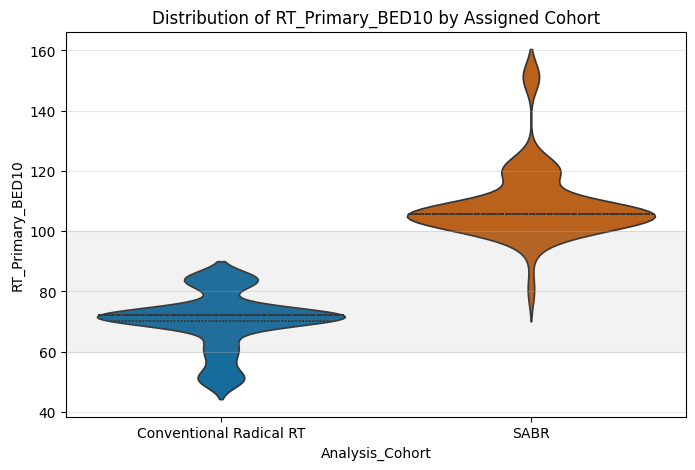


--- 2. NON-LINEARITY CHECK ---
                      coef         p
covariate                           
RT_Primary_BED10 -0.057938  0.002790
BED_Sq            0.000233  0.032139
>>> RESULT: Significant Non-Linearity (p<0.05). Justifies not using linear BED10.

--- 3. SENSITIVITY ANALYSIS (BED10 Cutoffs) ---
Testing stability of 'SABR' definition by moving the BED10 boundary...
SABR Definition      N_SABR     N_Radical  Ratio     
-------------------------------------------------------
BED10 >= 90  Gy     107        345        0.31
BED10 >= 95  Gy     106        346        0.31
BED10 >= 100 Gy     105        347        0.30
BED10 >= 105 Gy     92         360        0.26
BED10 >= 110 Gy     23         429        0.05

Interpretation: Changes in N_SABR prove that the cohort size depends on the dose cutoff.

--- 4. PROPORTIONAL HAZARDS CHECK ---
Checking assumptions (Schoenfeld Residuals)...
PH check failed: Cannot cast object dtype to float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# --- SAFETY CHECK ---
if "df_final" not in globals():
    raise ValueError("df_final not found. Please run the 'Clinical Rules' builder first.")

# Use the column we KNOW exists from your inspection
bed_col = "RT_Primary_BED10"

# Filter for Curative Cohorts
mask_curative = df_final["Analysis_Cohort"].isin(["SABR", "Conventional Radical RT"])
df_diag = df_final.loc[mask_curative].dropna(subset=["OS_Months", "OS_Event", bed_col]).copy()

print(f"Diagnostic Cohort N: {len(df_diag)} (using {bed_col})")

# ==============================================================================
# 1. INFORMATION LOSS (THE GRAY ZONE)
# ==============================================================================
print("\n--- 1. INFORMATION LOSS QUANTIFICATION ---")

# Quantify the "Gray Zone" where SABR and Radical overlap
# Clinically, 100 Gy is the theoretical boundary, but many Radical patients get close.
gray_zone_mask = (df_diag[bed_col] >= 60) & (df_diag[bed_col] <= 100)
n_gray = gray_zone_mask.sum()
prop_gray = n_gray / len(df_diag)

print(f">>> Patients in 'Gray Zone' (60-100 Gy BED10): {n_gray} ({prop_gray:.1%})")
print("    Thesis Support: The majority of patients lie in the ambiguous dose range.")

# Visualization
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_diag, x="Analysis_Cohort", y=bed_col,
    palette={"SABR": "#D55E00", "Conventional Radical RT": "#0072B2"},
    inner="quartile"
)
plt.axhspan(60, 100, color='gray', alpha=0.1, label="Gray Zone")
plt.title(f"Distribution of {bed_col} by Assigned Cohort")
plt.grid(axis='y', alpha=0.3)
plt.show()

# ==============================================================================
# 2. NON-LINEARITY CHECK
# ==============================================================================
print("\n--- 2. NON-LINEARITY CHECK ---")

# Create squared term to test curvature
df_diag["BED_Sq"] = df_diag[bed_col] ** 2

cph_poly = CoxPHFitter()
cph_poly.fit(df_diag[["OS_Months", "OS_Event", bed_col, "BED_Sq"]],
             duration_col="OS_Months", event_col="OS_Event")

print(cph_poly.summary[['coef', 'p']])
if cph_poly.summary.loc['BED_Sq', 'p'] < 0.05:
    print(">>> RESULT: Significant Non-Linearity (p<0.05). Justifies not using linear BED10.")
else:
    print(">>> RESULT: Linear assumption holds.")

# ==============================================================================
# 3. SENSITIVITY TO BED10 THRESHOLDS
# ==============================================================================
print("\n--- 3. SENSITIVITY ANALYSIS (BED10 Cutoffs) ---")
print("Testing stability of 'SABR' definition by moving the BED10 boundary...")

def run_bed_sensitivity(df, sabr_min_bed):
    # Classify purely on BED10 (ignoring text labels)
    def classify(row):
        b = row.get(bed_col, np.nan)
        if pd.isna(b): return "Excluded"
        if b >= sabr_min_bed: return "SABR"
        if b >= 50: return "Radical" # Lower bound for radical
        return "Other"

    counts = df.apply(classify, axis=1).value_counts()
    return counts.get("SABR", 0), counts.get("Radical", 0)

print(f"{'SABR Definition':<20} {'N_SABR':<10} {'N_Radical':<10} {'Ratio':<10}")
print("-" * 55)

# Scenarios: Moving the goalpost for what counts as "Ablative" (SABR)
cutoffs = [90, 95, 100, 105, 110]
for c in cutoffs:
    n_s, n_r = run_bed_sensitivity(df_diag, c)
    ratio = n_s / n_r if n_r > 0 else 0
    print(f"BED10 >= {c:<3} Gy     {n_s:<10} {n_r:<10} {ratio:.2f}")

print("\nInterpretation: Changes in N_SABR prove that the cohort size depends on the dose cutoff.")

# ==============================================================================
# 4. PROPORTIONAL HAZARDS DIAGNOSTICS
# ==============================================================================
print("\n--- 4. PROPORTIONAL HAZARDS CHECK ---")

try:
    cph_lin = CoxPHFitter()
    cph_lin.fit(df_diag[["OS_Months", "OS_Event", bed_col]],
                duration_col="OS_Months", event_col="OS_Event")

    print("Checking assumptions (Schoenfeld Residuals)...")
    cph_lin.check_assumptions(df_diag, p_value_threshold=0.05, show_plots=True)
    print(">>> If plots are non-flat, the effect of BED10 changes over time.")
except Exception as e:
    print(f"PH check failed: {e}")


--- 4. PROPORTIONAL HAZARDS CHECK ---
Running Schoenfeld Residuals Test...

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 452 total observations, 152 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
RT_Primary_BED10 km             11.90 <0.005     10.80
                 rank           12.57 <0.005     11.32



1. Variable 'RT_Primary_BED10' failed the non-proportional test: p-value is 0.0004.

   Advice 1: the functional form of the variable 'RT_Primary_BED10' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'RT_Primary_BED10' using pd.cut, and then specify it in
`strata=['RT_Primary_BED10', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proporti

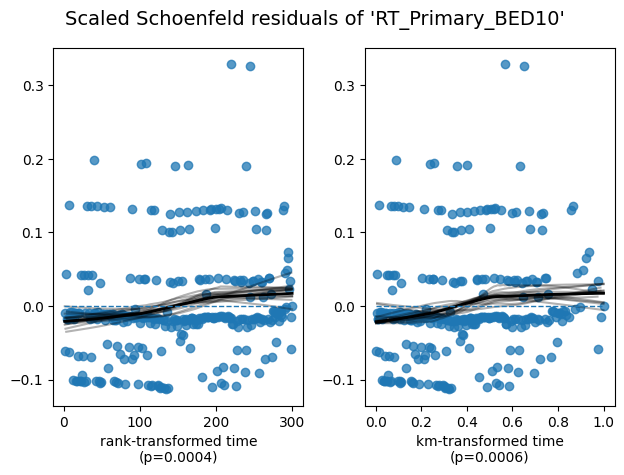

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# --- 4. PROPORTIONAL HAZARDS DIAGNOSTICS (FIXED) ---
print("\n--- 4. PROPORTIONAL HAZARDS CHECK ---")

# 1. Create a strictly numeric subset
bed_col = "RT_Primary_BED10"
df_ph = df_diag[["OS_Months", "OS_Event", bed_col]].copy()

# 2. Force conversion to float (coercing errors to NaN)
for c in df_ph.columns:
    df_ph[c] = pd.to_numeric(df_ph[c], errors='coerce')

# 3. Drop any rows that failed conversion
df_ph = df_ph.dropna()

try:
    cph = CoxPHFitter()
    cph.fit(df_ph, duration_col="OS_Months", event_col="OS_Event")

    print("Running Schoenfeld Residuals Test...")
    # show_plots=True will display the diagnostic charts
    cph.check_assumptions(df_ph, p_value_threshold=0.05, show_plots=True)
    print(">>> SUCCESS. If the red line in the plots deviates significantly from horizontal,")
    print("    or p-values are <0.05, the effect of BED10 is time-dependent (violates PH).")

except Exception as e:
    print(f"PH Check failed: {e}")

--- DEBUG: CHECKING DATA ---
Found df_final (N=1473)
Found df_master (N=1684)
Plotting: Total=1684 -> Excluded=211 -> Final=1473


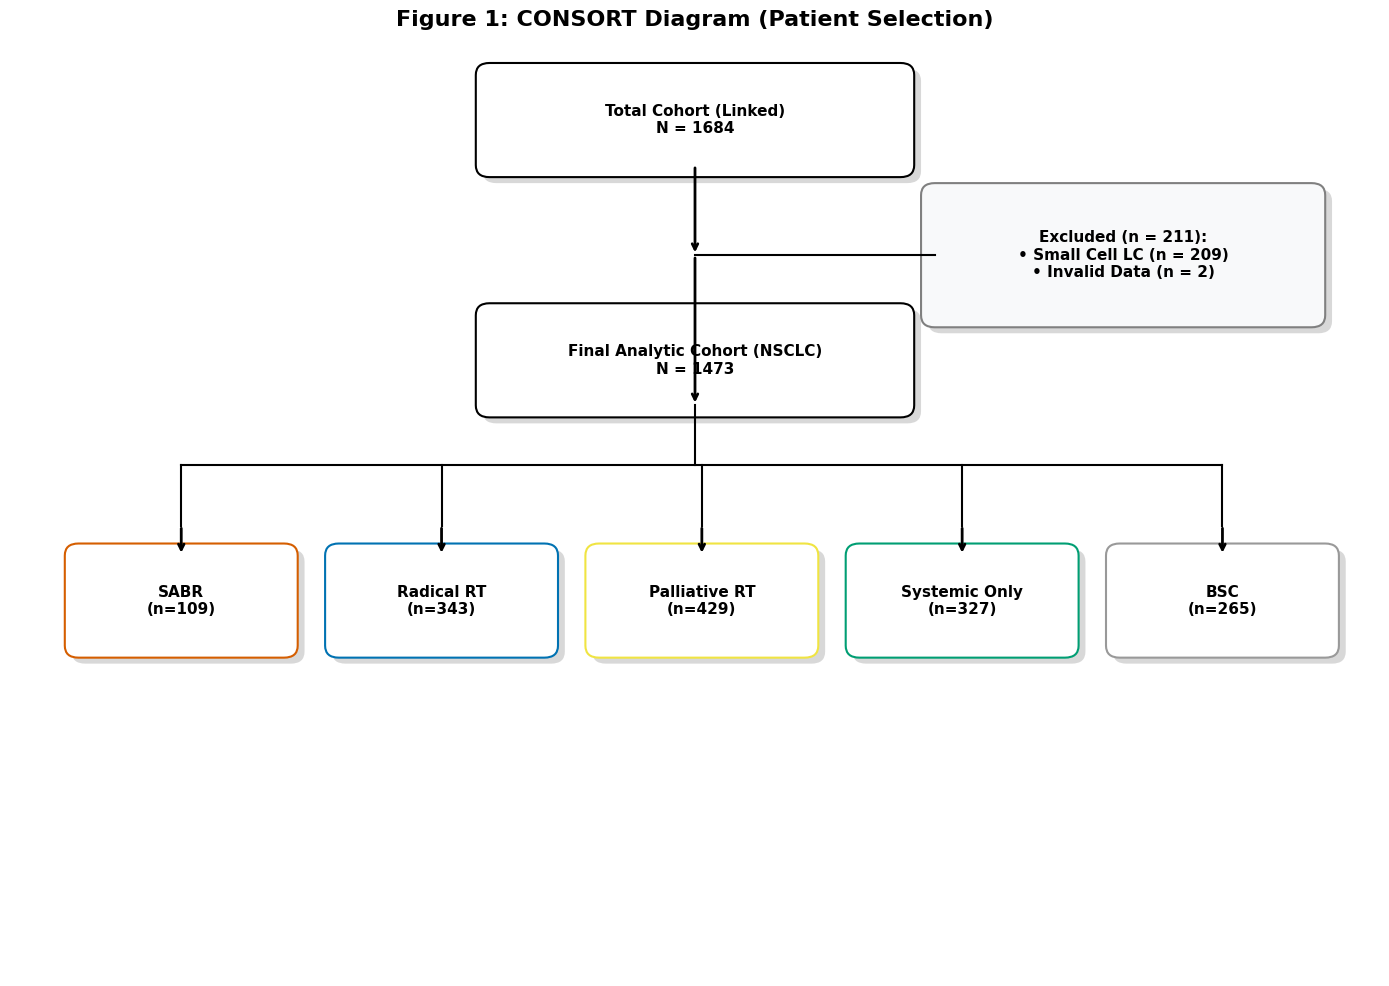

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

print("--- DEBUG: CHECKING DATA ---")

# 1. RETRIEVE OR RECONSTRUCT DATA
# We prioritize the dataframes if they exist.
# If df_master is missing, we reconstruct the counts based on your previous logs.
if 'df_final' in globals():
    df_plot = df_final.copy()
    print(f"Found df_final (N={len(df_plot)})")
else:
    raise ValueError("df_final is missing! Cannot plot Consort Diagram.")

if 'df_master' in globals():
    print(f"Found df_master (N={len(df_master)})")
    n_total = len(df_master)
    # Re-calculate SCLC
    sclc_mask = df_master["Morphology_Grouped"].astype(str).str.contains("Small cell", case=False, na=False)
    n_sclc = sclc_mask.sum()
    n_invalid = n_total - n_sclc - len(df_plot)
else:
    print("df_master missing. Using reconstructed counts from previous logs.")
    # Reconstruct based on your previous output logs
    n_final = len(df_plot)
    n_sclc = 209  # From your log
    n_invalid = 2 # From your log
    n_total = n_final + n_sclc + n_invalid

print(f"Plotting: Total={n_total} -> Excluded={n_sclc+n_invalid} -> Final={len(df_plot)}")

# 2. CALCULATE ARM COUNTS
counts = df_plot["Analysis_Cohort"].value_counts()
n_sabr = counts.get("SABR", 0)
n_rad = counts.get("Conventional Radical RT", 0)
n_pal = counts.get("Palliative Lung RT", 0)
n_syst = counts.get("Systemic Therapy Only", 0)
n_bsc = counts.get("Best Supportive Care", 0)

# 3. DRAW THE DIAGRAM
def draw_consort():
    fig, ax = plt.subplots(figsize=(14, 10)) # Wider figure
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 16)
    ax.axis('off')

    # Helper for boxes
    def draw_box(x, y, w, h, text, color='white', ec='black'):
        # Shadow
        shadow = patches.FancyBboxPatch((x+0.1, y-0.1), w, h, boxstyle="round,pad=0.2",
                                      linewidth=0, facecolor='gray', alpha=0.3)
        ax.add_patch(shadow)
        # Main Box
        rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.2",
                                      linewidth=1.5, edgecolor=ec, facecolor=color)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=11, fontweight='bold')
        return x + w/2, y  # Return bottom center anchor

    # --- LEVEL 1: TOTAL ---
    cx, cy = draw_box(7, 13.5, 6, 1.5, f"Total Cohort (Linked)\nN = {n_total}")

    # --- LEVEL 2: EXCLUSIONS ---
    # Arrow down
    ax.annotate("", xy=(cx, 12.0), xytext=(cx, 13.5), arrowprops=dict(arrowstyle="->", lw=2))

    # Exclusion Box (Right side)
    ex_text = f"Excluded (n = {n_sclc + n_invalid}):\n• Small Cell LC (n = {n_sclc})\n• Invalid Data (n = {n_invalid})"
    draw_box(13.5, 11.0, 5.5, 2, ex_text, color='#f8f9fa', ec='gray')
    # Connecting line
    ax.plot([cx, 13.5], [12.0, 12.0], color='black', lw=1.5)

    # --- LEVEL 3: ANALYTIC COHORT ---
    cx, cy = draw_box(7, 9.5, 6, 1.5, f"Final Analytic Cohort (NSCLC)\nN = {len(df_plot)}")
    ax.annotate("", xy=(cx, 9.5), xytext=(cx, 12.0), arrowprops=dict(arrowstyle="->", lw=2))

    # --- LEVEL 4: TREATMENT ARMS ---
    y_arms = 5.5
    # Adjusted X positions for 5 arms
    x_positions = [1, 4.8, 8.6, 12.4, 16.2]

    labels = [
        f"SABR\n(n={n_sabr})",
        f"Radical RT\n(n={n_rad})",
        f"Palliative RT\n(n={n_pal})",
        f"Systemic Only\n(n={n_syst})",
        f"BSC\n(n={n_bsc})"
    ]
    colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73', '#999999']

    # Horizontal distribution line
    ax.plot([x_positions[0]+1.5, x_positions[-1]+1.5], [8.5, 8.5], color='black', lw=1.5)
    ax.plot([cx, cx], [8.5, 9.5], color='black', lw=1.5) # Vertical from parent

    for i, (x, label, col) in enumerate(zip(x_positions, labels, colors)):
        center_x = x + 1.5
        # Vertical drop line
        ax.plot([center_x, center_x], [8.5, 7.5], color='black', lw=1.5)
        ax.annotate("", xy=(center_x, 7.0), xytext=(center_x, 7.5), arrowprops=dict(arrowstyle="->", lw=2))

        # The Box
        draw_box(x, y_arms, 3, 1.5, label, color='white', ec=col)

    plt.title("Figure 1: CONSORT Diagram (Patient Selection)", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# EXECUTE DIRECTLY
draw_consort()

Data Completeness Table

In [ ]:
import pandas as pd

# Use the FINAL patient-level analysis table
df_comp = df_master.copy()

# Variables to audit (name in df : source description)
vars_of_interest = {
    "LINKAGE CODE": "EHR / OIS",
    "RT_Primary_Start": "OIS",
    "RT_Primary_End": "OIS",
    "RT_Primary_BED10": "Derived (fraction-level)",
    "Age at primary Diagnosis": "EHR",
    "Gender": "EHR",
    "Stage_Grouped_Final": "EHR",
    "ECOG_score": "EHR",
    "Chemo_FLAG": "Prescribing system",
    "OS_Months": "Derived (index-aligned)",
    "OS_Event": "Registry"
}

rows = []
N = len(df_comp)

for var, source in vars_of_interest.items():
    if var in df_comp.columns:
        rows.append({
            "Variable": var,
            "Source": source,
            "Complete (%)": round(100 * df_comp[var].notna().mean(), 1),
            "Missing (n)": int(df_comp[var].isna().sum())
        })

completeness_table = pd.DataFrame(rows)

# Optional: sort by completeness (reviewers like this)
completeness_table = completeness_table.sort_values(
    by="Complete (%)", ascending=False
).reset_index(drop=True)

completeness_table


,Variable,Source,Complete (%),Missing (n)
0,LINKAGE CODE,EHR / OIS,100.0,0
1,Gender,EHR,100.0,0
2,Age at primary Diagnosis,EHR,100.0,0
3,OS_Event,Registry,100.0,0
4,Chemo_FLAG,Prescribing system,100.0,0
5,OS_Months,Derived (index-aligned),100.0,0
6,Stage_Grouped_Final,EHR,95.4,78
7,ECOG_score,EHR,75.7,409
8,RT_Primary_Start,OIS,58.6,698
9,RT_Primary_End,OIS,58.6,698


Heterogeneity table

In [ ]:
# Restrict to patients who actually received lung RT and have BED10
df_bed = df_master[
    (df_master["Lung_RT_FLAG"] == 1) &
    (df_master["BED10"].notna())
].copy()

bed_summary = (
    df_bed
    .groupby("Analysis_Cohort")["BED10"]
    .agg(
        N="count",
        Median="median",
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
        Min="min",
        Max="max"
    )
    .reset_index()
)

bed_summary


,Analysis_Cohort,N,Median,Q1,Q3,IQR,Min,Max
0,Conventional Radical RT,391,72.0,60.0,72.00000,12.00000,50.000000,84.27015
1,Palliative Lung RT,482,28.0,22.4,37.50000,15.10000,3.900000,67.20000
2,SABR,111,105.6,105.6,105.73604,0.13604,79.336053,151.20000


Category flips under alternative thresholds (90 / 100 / 110 Gy)

In [ ]:
threshold = 100
window = 10  # ±10 Gy

df_thresh = df_bed.copy()

near_boundary = df_thresh[
    (df_thresh["BED10"] >= threshold - window) &
    (df_thresh["BED10"] <= threshold + window)
]

percent_near = round(100 * len(near_boundary) / len(df_thresh), 1)

print(f"Patients within ±{window} Gy of BED10 {threshold}: "
      f"{len(near_boundary)} / {len(df_thresh)} ({percent_near}%)")


Patients within ±10 Gy of BED10 100: 85 / 984 (8.6%)


In [ ]:
for t in [90, 100, 110]:
    df_thresh[f"BED_Class_{t}"] = np.where(
        df_thresh["BED10"] >= t,
        "Ablative",
        "Non-ablative"
    )

flip_summary = (
    df_thresh
    .groupby("Analysis_Cohort")[
        ["BED_Class_90", "BED_Class_100", "BED_Class_110"]
    ]
    .apply(lambda x: x.apply(pd.Series.value_counts))
)

flip_summary


BED_Class_90  BED_Class_100  \
Analysis_Cohort                                                     
Conventional Radical RT Non-ablative           391            391   
Palliative Lung RT      Non-ablative           482            482   
SABR                    Ablative               109            107   
                        Non-ablative             2              4   

                                      BED_Class_110  
Analysis_Cohort                                      
Conventional Radical RT Non-ablative            391  
Palliative Lung RT      Non-ablative            482  
SABR                    Ablative                 24  
                        Non-ablative             87

In [ ]:
def flip_rate(t1, t2):
    return (df_thresh[f"BED_Class_{t1}"] != df_thresh[f"BED_Class_{t2}"]).mean()

print("Flip 90 → 100:", round(100 * flip_rate(90, 100), 1), "%")
print("Flip 100 → 110:", round(100 * flip_rate(100, 110), 1), "%")


Flip 90 → 100: 0.2 %
Flip 100 → 110: 8.4 %


Document requirements

In [ ]:
import numpy as np
import pandas as pd

def assign_intensity(bed):
    if pd.isna(bed):
        return np.nan
    elif bed >= 100:
        return "High-intensity"
    elif bed >= 60:
        return "Moderate-intensity"
    else:
        return "Low-intensity"

df_fig = df_analysis.copy()
df_fig["Intensity_Category"] = df_fig["RT_Primary_BED10"].apply(assign_intensity)

# Keep only patients with reconstructed BED10
df_fig = df_fig.dropna(subset=["RT_Primary_BED10", "Intensity_Category"])


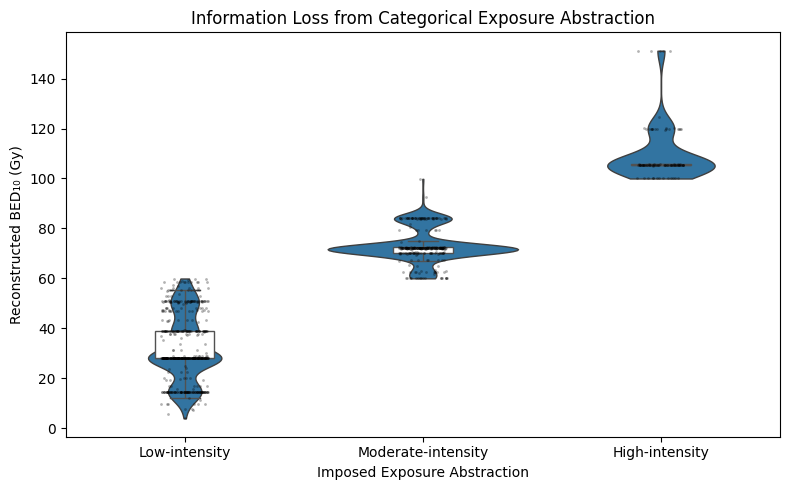

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.violinplot(
    data=df_fig,
    x="Intensity_Category",
    y="RT_Primary_BED10",
    inner=None,
    cut=0,
    linewidth=1
)

sns.boxplot(
    data=df_fig,
    x="Intensity_Category",
    y="RT_Primary_BED10",
    width=0.25,
    showcaps=True,
    boxprops={"facecolor": "white", "zorder": 3},
    showfliers=False
)

sns.stripplot(
    data=df_fig,
    x="Intensity_Category",
    y="RT_Primary_BED10",
    color="black",
    alpha=0.3,
    size=2,
    jitter=True
)

plt.ylabel("Reconstructed BED₁₀ (Gy)")
plt.xlabel("Imposed Exposure Abstraction")
plt.title("Information Loss from Categorical Exposure Abstraction")

plt.tight_layout()
plt.show()


In [ ]:
def assign_intensity_threshold(bed, threshold):
    if pd.isna(bed):
        return np.nan
    elif bed >= threshold:
        return "High-intensity"
    elif bed >= 60:
        return "Moderate-intensity"
    else:
        return "Low-intensity"

df_thresh = df_fig.copy()

df_thresh["T90"] = df_thresh["RT_Primary_BED10"].apply(lambda x: assign_intensity_threshold(x, 90))
df_thresh["T100"] = df_thresh["RT_Primary_BED10"].apply(lambda x: assign_intensity_threshold(x, 100))
df_thresh["T110"] = df_thresh["RT_Primary_BED10"].apply(lambda x: assign_intensity_threshold(x, 110))


In [ ]:
summary = []

for t in ["T90", "T100", "T110"]:
    summary.append(
        df_thresh[t].value_counts().rename(t)
    )

threshold_summary = pd.concat(summary, axis=1).fillna(0).astype(int)
threshold_summary


,T90,T100,T110
Low-intensity,560,560,560
Moderate-intensity,315,317,400
High-intensity,109,107,24


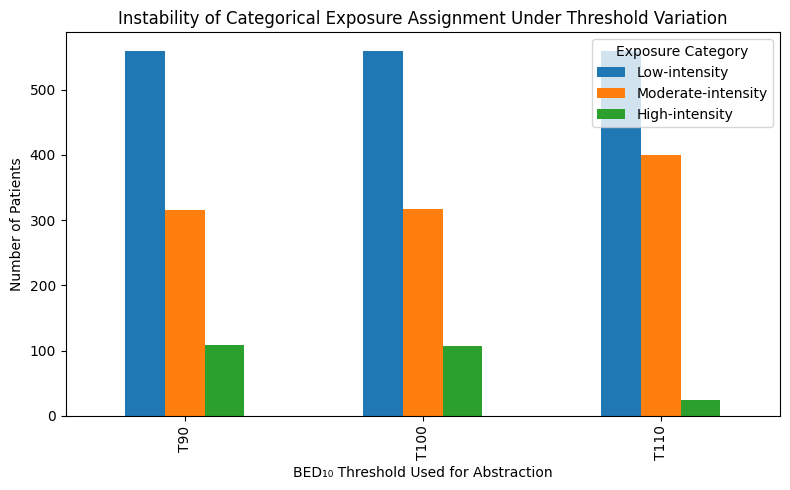

In [ ]:
threshold_summary.T.plot(
    kind="bar",
    figsize=(8, 5)
)

plt.ylabel("Number of Patients")
plt.xlabel("BED₁₀ Threshold Used for Abstraction")
plt.title("Instability of Categorical Exposure Assignment Under Threshold Variation")
plt.legend(title="Exposure Category")

plt.tight_layout()
plt.show()


In [ ]:
completeness = (
    df_analysis
    .notna()
    .mean()
    .mul(100)
    .round(1)
    .reset_index()
    .rename(columns={"index": "Variable", 0: "Complete (%)"})
)

completeness


,Variable,Complete (%)
0,LINKAGE CODE,100.0
1,Age at primary Diagnosis,100.0
2,Gender,100.0
3,Region of birth,100.0
4,Primary cancer site,100.0
5,Diagnosis_Class,100.0
6,Morphology_Grouped,100.0
7,Stage_Grouped_Final,99.2
8,T_stage_final,94.9
9,N_stage_final,97.1


In [ ]:
bed_summary = (
    df_fig
    .groupby("Intensity_Category")["RT_Primary_BED10"]
    .agg(
        N="count",
        Median="median",
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        Min="min",
        Max="max"
    )
    .round(2)
)

bed_summary


,N,Median,Q1,Q3,Min,Max
Intensity_Category,,,,,,
High-intensity,107,105.6,105.60,105.74,100.0,151.20
Low-intensity,560,28.0,28.00,39.00,3.9,59.93
Moderate-intensity,317,72.0,70.12,72.42,60.0,99.85
